In [1]:
%matplotlib notebook
import os
import numpy as np
import pandas as pd
import sqlite3
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
import lsst.geom
import matplotlib.ticker as plticker
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)
import astropy.units as u

import matplotlib.pyplot as plt

afwDisplay.setDefaultBackend('matplotlib')

In [2]:
cwpRepo = '/home/gkovacs/data/repo_DM-17825/ingested/rerun/proc_2019-02-21'
#dcrRepo = '/project/mrawls/hits2015/rerun/dcr_processed2'
cwpTemplateRepo = '/home/gkovacs/data/repo_DM-17825/templates'
#dcrTemplateRepo = '/project/mrawls/hits2014/dcrcoadds_processed2'

In [3]:
butlerCwp = dafPersist.Butler(cwpRepo)
butlerCwpTemplate = dafPersist.Butler(cwpTemplateRepo)

In [4]:
def loadAllPpdbObjects(repo, dbName='association.db'):
    """Load select DIAObject columns from a PPDB into a pandas dataframe.

    Parameters
    ----------
    repo : `str`
        Path to an output repository from an ap_pipe run.
    dbName : `str`, optional
        Name of the PPDB, which must reside in (or relative to) repo.

    Returns
    -------
    objTable : `pandas.DataFrame`
        DIA Object Table containing only objects with validityEnd NULL.
        Columns selected are presently hard-wired here.
    """
    connection = sqlite3.connect(os.path.join(repo, dbName))

    # These are the tables available in the ppdb
    tables = {'obj': 'DiaObject', 'src': 'DiaSource', 'ccd': 'CcdVisit'}

    # Only get objects with validityEnd NULL because that means they are still valid
    objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources, \
                                  gPSFluxMean, validityEnd, flags from {0} \
                                  where validityEnd is NULL;'.format(tables['obj']), connection)
    return objTable

In [5]:
def defMiniRegion(objTable):
    miniRegion = ((objTable['decl'] < -5.6) & (objTable['decl'] > -5.8) & 
               (objTable['ra'] > 155.2) & (objTable['ra'] < 155.3) &
               (objTable['nDiaSources'] > 2))
    return miniRegion

In [6]:
cwpObjTable = loadAllPpdbObjects(cwpRepo)
cwpMiniRegion = defMiniRegion(cwpObjTable)

In [7]:


def plotMiniRegion(objTable, miniRegion, title=None):
    print('Plotting {0} DIAObjects'.format(len(objTable.loc[miniRegion, 'ra'])))
    fig = plt.figure(figsize=(7,5))
    ax1 = fig.add_subplot(111)
    cb1 = ax1.scatter((objTable.loc[miniRegion, 'ra'].values*u.deg).to_value(u.rad),
                      (objTable.loc[miniRegion, 'decl'].values*u.deg).to_value(u.rad),
                      marker='.', lw=0, s=objTable.loc[miniRegion, 'nDiaSources']*8,
                      c=objTable.loc[miniRegion, 'flags'],  #c=objTable.loc[miniRegion, 'nDiaSources'],
                      alpha=0.5, )
                      #cmap=plt.cm.get_cmap('viridis'))
    binMax = np.max(objTable['nDiaSources'].values)
    #cbplot = plt.colorbar(cb1, ax=ax1)
    #cbplot.set_label('Number of DIASources')
    #cbplot.set_clim(0, binMax)
    #cbplot.solids.set_edgecolor("face")
    plt.xlabel('RA (rad)')
    plt.ylabel('Dec (rad)')
    #plt.xlim([155.3, 155.2])
    #plt.ylim([-5.8, -5.6])
    plt.xlim([2.71040, 2.70875])
    plt.ylim([-0.1014, -0.0978])
    if title:
        plt.title(title)



Plotting 144 DIAObjects


<IPython.core.display.Javascript object>


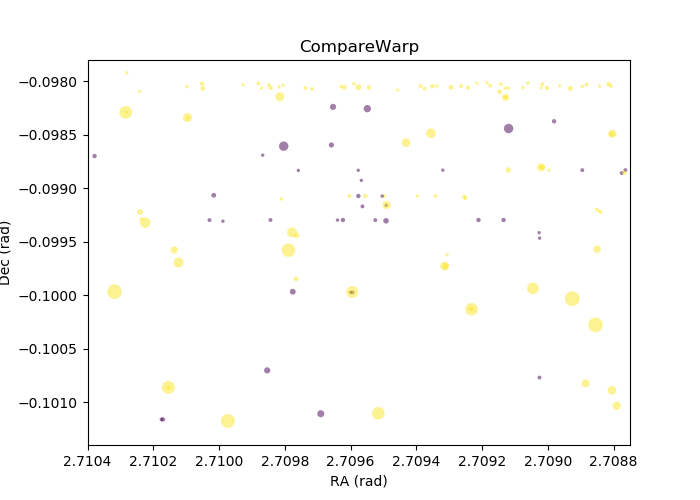

In [8]:
plotMiniRegion(cwpObjTable, cwpMiniRegion, title='CompareWarp')

In [9]:


def load_sources(repo, obj, sqliteFile='association.db'):
    connection = sqlite3.connect(os.path.join(repo, sqliteFile))
    tables = {'obj': 'DiaObject', 'src': 'DiaSource', 'ccd': 'CcdVisit'}
    srcTable = pd.read_sql_query('select diaSourceId, diaObjectId, ccdVisitId, midPointTai, \
                                 apFlux, psFlux, apFluxErr, psFluxErr, totFlux, totFluxErr, flags \
                                 from {1} where diaObjectId = {0};'.format(obj, tables['src']), connection)
    connection.close()
    return(srcTable)



In [10]:
def plot_lightcurve(repo, templateRepo, obj, patch, objTable, 
                    useTotFlux=False, plotAllCutouts=False, cutoutIdx=0, labelCutouts=False,
                    diffimType='deepDiff_differenceExp'):
    sources = load_sources(repo, obj)
    ra = objTable.loc[objTable['diaObjectId'] == obj, 'ra']
    dec = objTable.loc[objTable['diaObjectId'] == obj, 'decl']
    flags = sources['flags']    
    dataIds = sources['ccdVisitId'].values  # these are ints
    dataIdDicts = []
    for dataId in dataIds:
        visit = int(str(dataId)[0:6])
        ccdnum = int(str(dataId)[6:])
        dataIdDict = {'visit': visit, 'ccdnum': ccdnum}
        dataIdDicts.append(dataIdDict)
    centerSource = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
    size = lsst.geom.Extent2I(30, 30)
    
    print('DIAObject ID:', obj)
    #print('Flags:', flags)
    print('RA (deg):', ra.values)
    print('Dec (deg):', dec.values)
    print('DIASource IDs:', sources['diaSourceId'].values)
    print('Data IDs:', dataIdDicts)

    plt.figure()

    # light curve with psFlux by default (uses totFlux if useTotFlux=True)
    plt.subplot(212)
    plt.xlabel('Time (MJD)', size=16)
    if not useTotFlux:
        plt.errorbar(sources['midPointTai'], sources['psFlux']*1e9, yerr=sources['psFluxErr']*1e9, 
                     ls=':', marker='o', color='#2979C1')
        plt.ylabel('Difference Flux (nJy)', size=16)
    else:
        plt.errorbar(sources['midPointTai'], ources['totFlux']*1e9, yerr=sources['totFluxErr']*1e9,
                     ls=':', marker='o', color='#2979C1')
        plt.ylabel('Flux (nJy)', size=16)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)    
    
    # processed image
    plt.subplot(231)
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.title('Processed', size=16)
    butler = dafPersist.Butler(repo)
    calexpFirst = butler.get('calexp', dataIdDicts[cutoutIdx])
    calexpArray = calexpFirst.getCutout(centerSource, size).getMaskedImage().getImage().getArray()
    calexpNorm = ImageNormalize(calexpArray, interval=ZScaleInterval(), stretch=SqrtStretch())
    plt.imshow(np.rot90(np.fliplr(calexpArray)), cmap='gray', norm=calexpNorm)
    
    # template image
    plt.subplot(232)
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.title('Template', size=16)
    templateDataId = {'filter': 'g', 'tract': 0, 'patch': patch}
    butlerTemplate = dafPersist.Butler(templateRepo)
    template = butlerTemplate.get('deepCoadd', dataId=templateDataId)
    templateArray = template.getCutout(centerSource, size).getMaskedImage().getImage().getArray()
    templateNorm = ImageNormalize(templateArray, interval=ZScaleInterval(), stretch=SqrtStretch())
    plt.imshow(np.flipud(templateArray), cmap='gray', norm=templateNorm)
    #plt.imshow(np.fliplr(np.rot90(templateArray)), cmap='gray', norm=templateNorm)
    
    # difference image
    plt.subplot(233)
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.title('Difference', size=16)
    diffimFirst = butler.get(diffimType, dataIdDicts[cutoutIdx])
    diffimArray = diffimFirst.getCutout(centerSource, size).getMaskedImage().getImage().getArray()
    diffimNorm = ImageNormalize(diffimArray, interval=ZScaleInterval(), stretch=SqrtStretch())
    plt.imshow(np.rot90(np.fliplr(diffimArray)), cmap='gray', norm=diffimNorm)
    
    if plotAllCutouts:
        fig = plt.figure(figsize=(8,8))  # optional figure with cutouts for all visits
        fig.subplots_adjust(hspace=0, wspace=0)
        for idx, dataId in enumerate(dataIdDicts):
            calexp = butler.get('calexp', dataId)
            calexpArray = calexp.getCutout(centerSource, size).getMaskedImage().getImage().getArray()
            calexpNorm = ImageNormalize(calexpArray, interval=ZScaleInterval(), stretch=SqrtStretch())
            diffim = butler.get(diffimType, dataId)
            diffimArray = diffim.getCutout(centerSource, size).getMaskedImage().getImage().getArray()
            diffimNorm = ImageNormalize(diffimArray, interval=ZScaleInterval(), stretch=SqrtStretch())
            plt.subplot(10, 10, idx+1)
            plt.gca().get_xaxis().set_ticks([])
            plt.gca().get_yaxis().set_ticks([])
            plt.imshow(np.rot90(np.fliplr(calexpArray)), cmap='gray', norm=calexpNorm)
            if labelCutouts:
                if idx == 0:
                    plt.text(1, 26, 'Proc', color='lime', size=8)
                plt.text(2, 5, str(sources['midPointTai'][idx])[1:8], color='lime', size=8)            
            plt.subplot(10, 10, idx+50+1)
            plt.gca().get_xaxis().set_ticks([])
            plt.gca().get_yaxis().set_ticks([])
            plt.imshow(np.rot90(np.fliplr(diffimArray)), cmap='gray', norm=diffimNorm)
            if labelCutouts:
                if idx == 0:
                    plt.text(1, 26, 'Diff', color='lime', size=8)
                plt.text(2, 5, str(sources['midPointTai'][idx])[1:8], color='lime', size=8)

In [11]:
cwpObjList = list(cwpObjTable.loc[cwpMiniRegion, 'diaObjectId'])
cwpMiniUnflagged = cwpMiniRegion & (cwpObjTable['flags'] == 0)
cwpObjMiniList = list(cwpObjTable.loc[cwpMiniUnflagged, 'diaObjectId'])

In [12]:

cwpObjMiniList = list(cwpObjTable.loc[cwpMiniUnflagged, 'diaObjectId'])


In [13]:
patchList = ['10,8', '11,8', '12,8', '13,8',
             '10,7', '11,7', '12,7', '13,7',
             '10,9', '11,9', '12,9', '13,9',
             '10,5', '11,5', '12,5', '13,5',
             '10,6', '11,6', '12,6', '13,6',
             '10,10', '11,10', '12,10', '13,10']

In [14]:


def patchFinder(obj, objTable, templateButler, patchList):
    for patch in patchList:
        ra = objTable.loc[objTable['diaObjectId'] == obj, 'ra']
        dec = objTable.loc[objTable['diaObjectId'] == obj, 'decl']
        centerSource = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
        size = lsst.geom.Extent2I(30, 30)
        templateDataId = {'filter': 'g', 'tract': 0, 'patch': patch}
        templateImage = templateButler.get('deepCoadd', dataId=templateDataId)
        try:
            cutout = templateImage.getCutout(centerSource, size)
        except:
            continue
        else:
            templatePatch = patch
            #print('template patch:', templatePatch)
            #print('object id:', obj)
            return templatePatch
            break



In [15]:
patch = patchFinder(cwpObjList[0], cwpObjTable, butlerCwpTemplate, patchList)
cwpTemplate = butlerCwpTemplate.get('deepCoadd', dataId={'filter': 'g', 'tract': 0, 'patch': patch})

In [16]:
patch

'11,8'

In [ ]:
plot_lightcurve(cwpRepo, cwpTemplateRepo, cwpObjList[1], 
                patch, cwpObjTable, plotAllCutouts=True)

DIAObject ID: 176538214020939988
RA (deg): [155.21571193]
Dec (deg): [-5.77363938]
DIASource IDs: [176538214020939988 176703570261835975 176725045098316008
 176876227947135179]
Data IDs: [{'visit': 411035, 'ccdnum': 6}, {'visit': 411420, 'ccdnum': 6}, {'visit': 411470, 'ccdnum': 6}, {'visit': 411822, 'ccdnum': 6}]


<IPython.core.display.Javascript object>


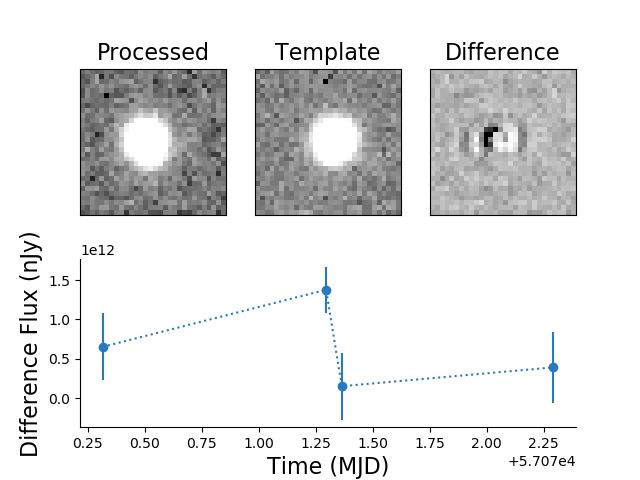

<IPython.core.display.Javascript object>


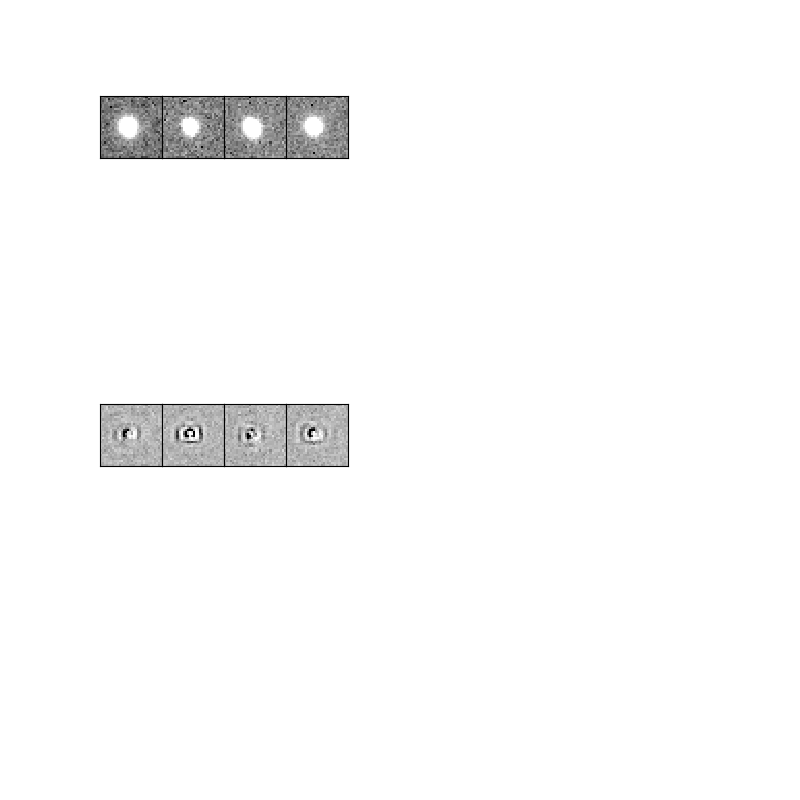

DIAObject ID: 176516739184459947
RA (deg): [155.2631706]
Dec (deg): [-5.76981764]
DIASource IDs: [176516739184459947 176538214020939999 176638716255666409
 176660191092146422 176681665928626398 176725045098316022
 176854753110655171 176876227947135191 177680245824946379
 178403518317592721]
Data IDs: [{'visit': 410985, 'ccdnum': 6}, {'visit': 411035, 'ccdnum': 6}, {'visit': 411269, 'ccdnum': 6}, {'visit': 411319, 'ccdnum': 6}, {'visit': 411369, 'ccdnum': 6}, {'visit': 411470, 'ccdnum': 6}, {'visit': 411772, 'ccdnum': 6}, {'visit': 411822, 'ccdnum': 6}, {'visit': 413694, 'ccdnum': 6}, {'visit': 415378, 'ccdnum': 6}]


<IPython.core.display.Javascript object>


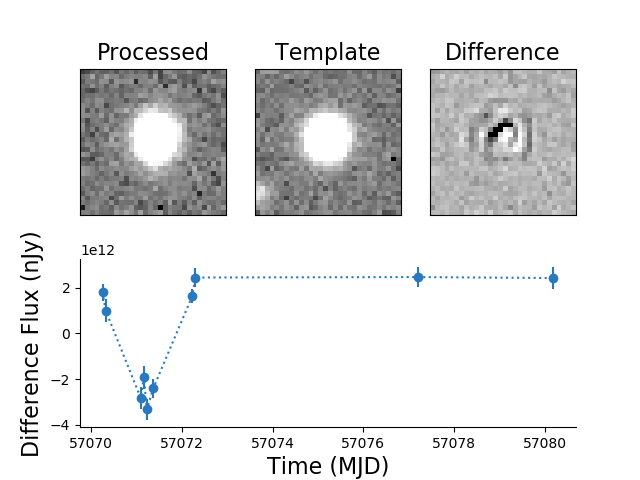

<IPython.core.display.Javascript object>


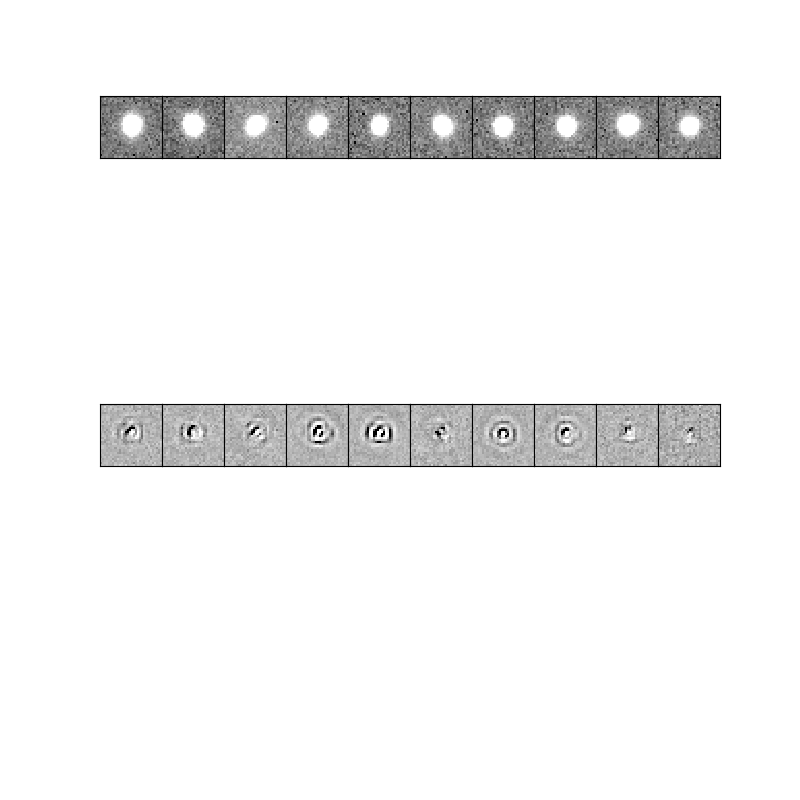

DIAObject ID: 176493765404393884
RA (deg): [155.20075574]
Dec (deg): [-5.66253023]
DIASource IDs: [176493765404393884 176661269128937860 176682743965418128
 176704648298627854]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


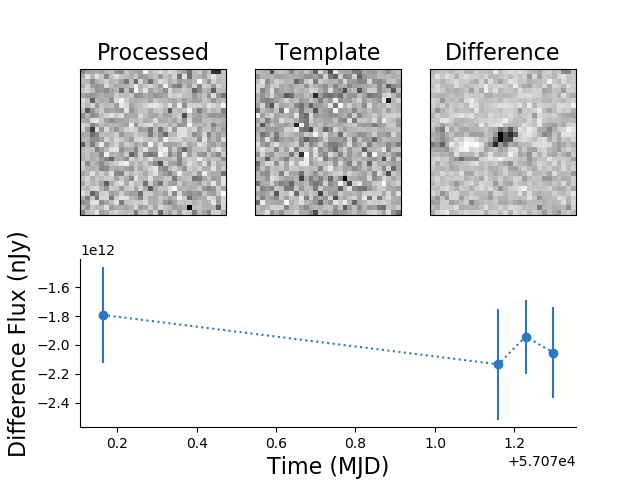

<IPython.core.display.Javascript object>


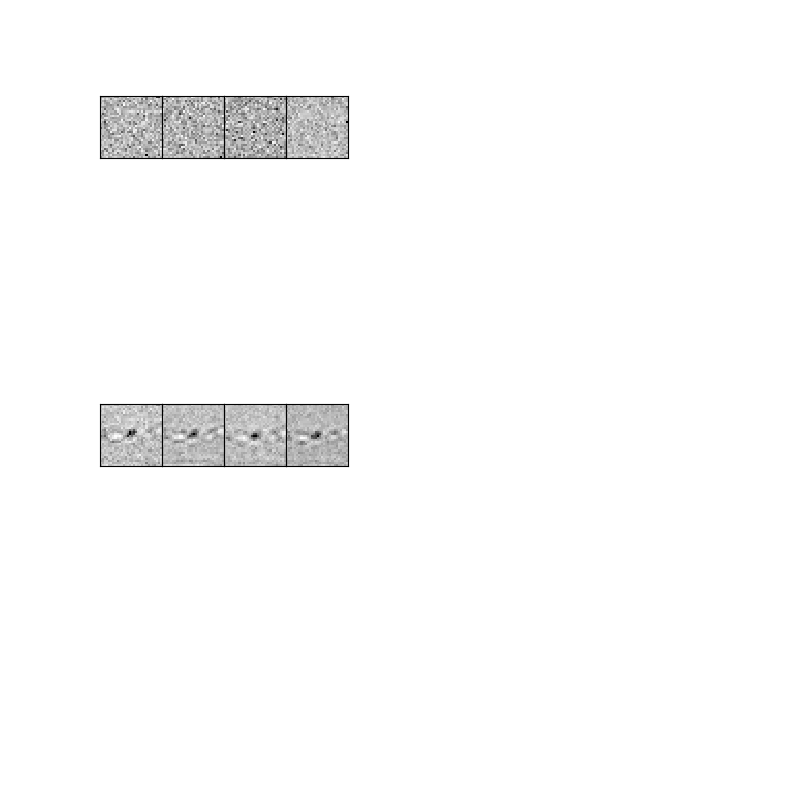

DIAObject ID: 176493765404393885
RA (deg): [155.20138315]
Dec (deg): [-5.66408916]
DIASource IDs: [176493765404393885 176661269128937861 176682743965418129
 176704648298627856]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


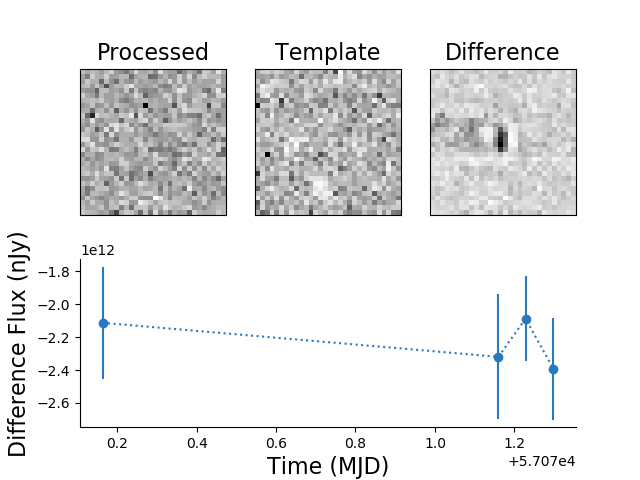

<IPython.core.display.Javascript object>


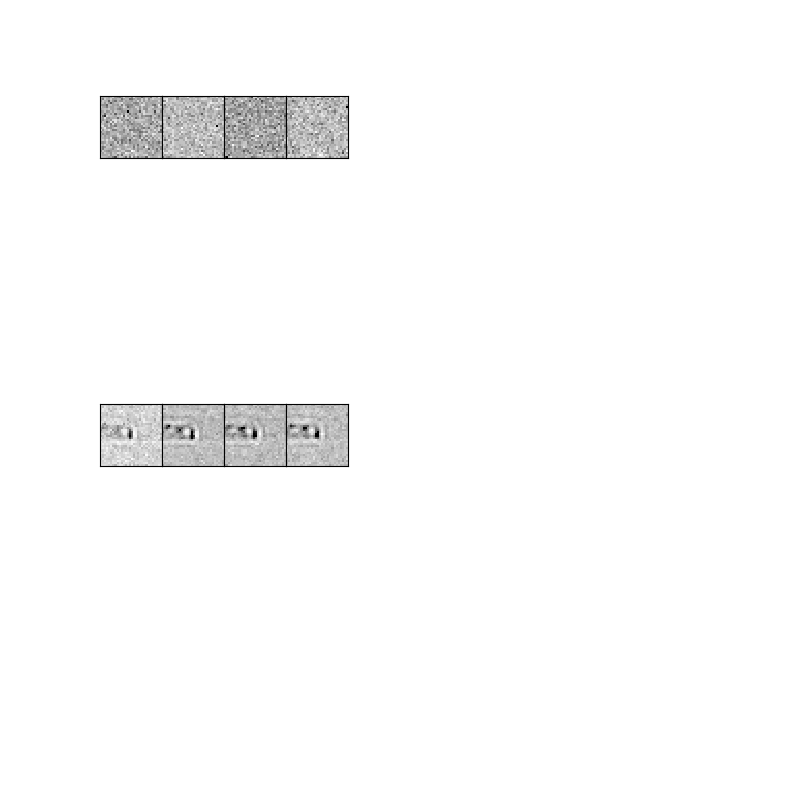

DIAObject ID: 176493765404393893
RA (deg): [155.20825571]
Dec (deg): [-5.6625302]
DIASource IDs: [176493765404393893 176661269128937869 176682743965418145
 176704648298627867]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


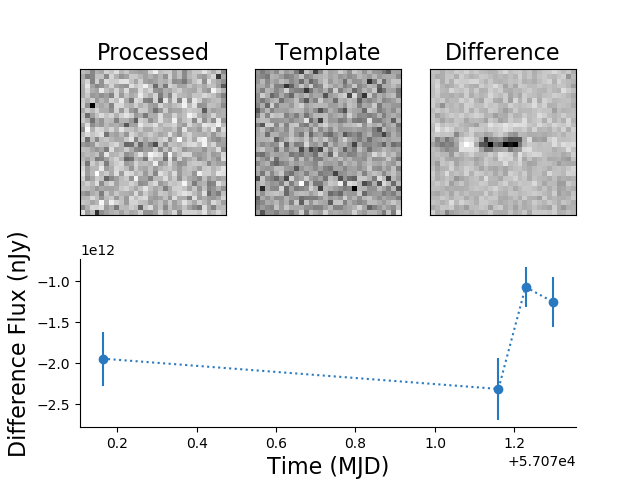

<IPython.core.display.Javascript object>


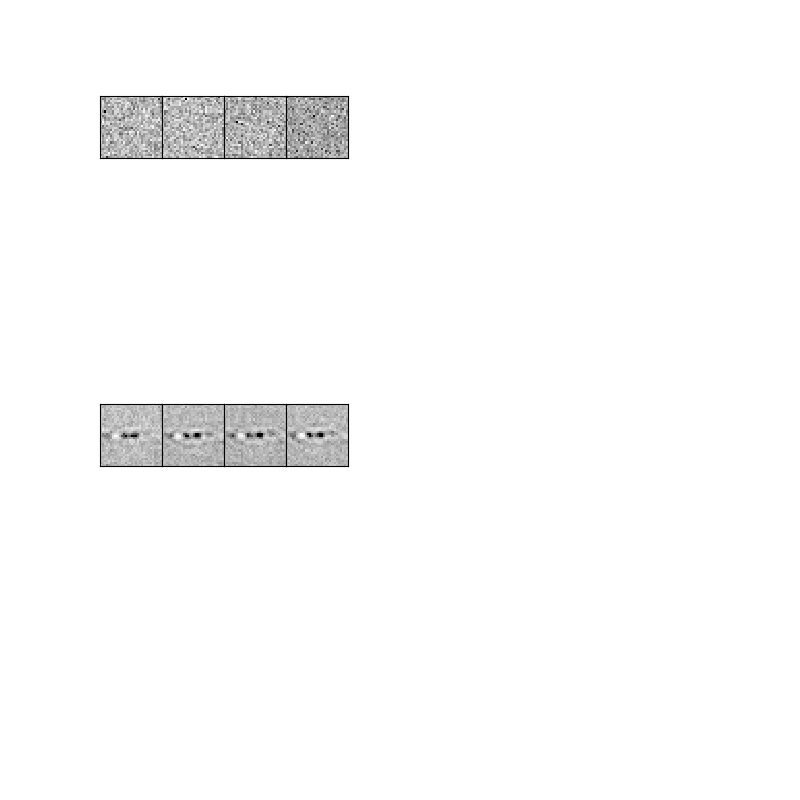

DIAObject ID: 176661269128937879
RA (deg): [155.21569012]
Dec (deg): [-5.69896099]
DIASource IDs: [176661269128937879 176682743965418160 176704648298627884]
Data IDs: [{'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


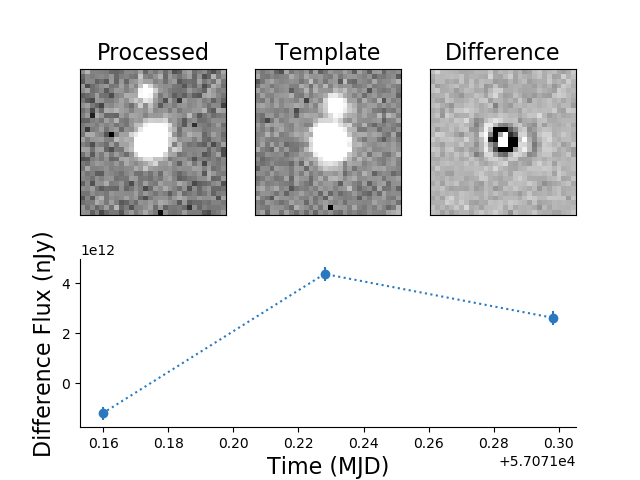

<IPython.core.display.Javascript object>


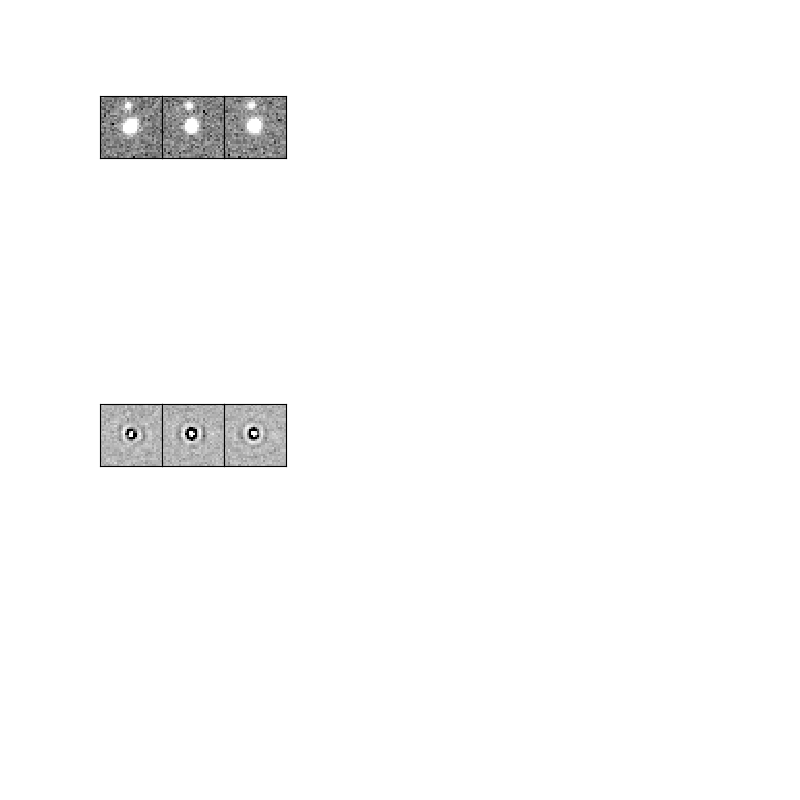

DIAObject ID: 176661269128937880
RA (deg): [155.2157799]
Dec (deg): [-5.69604155]
DIASource IDs: [176661269128937880 176682743965418161 176704648298627885]
Data IDs: [{'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


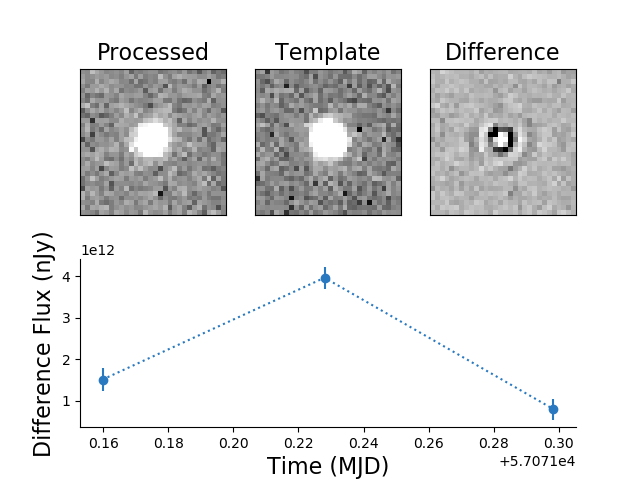

<IPython.core.display.Javascript object>


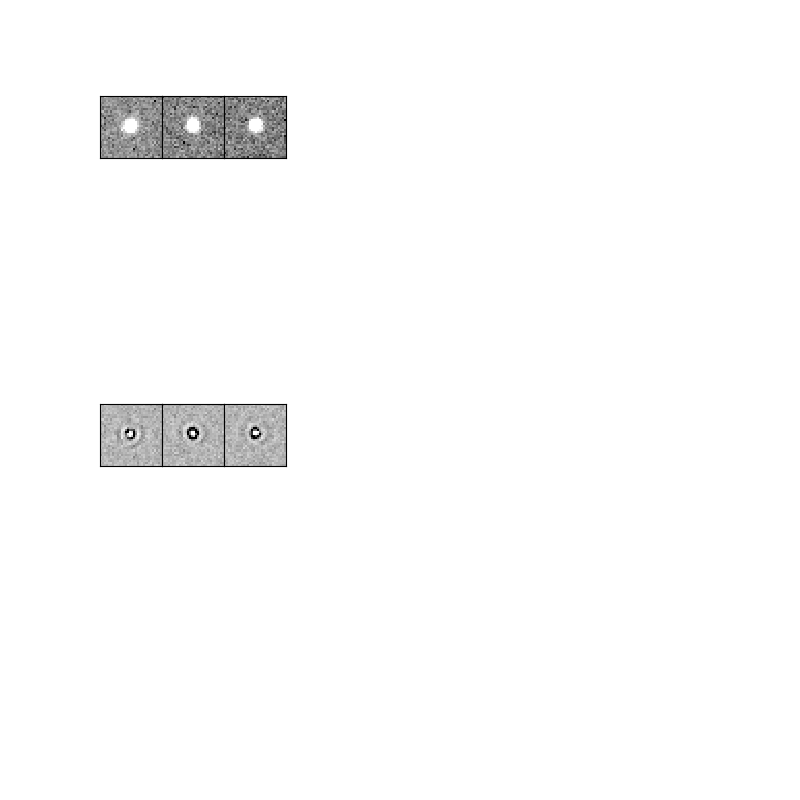

DIAObject ID: 176661269128937927
RA (deg): [155.26394993]
Dec (deg): [-5.65450964]
DIASource IDs: [176661269128937927 176682743965418255 176704648298627999]
Data IDs: [{'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


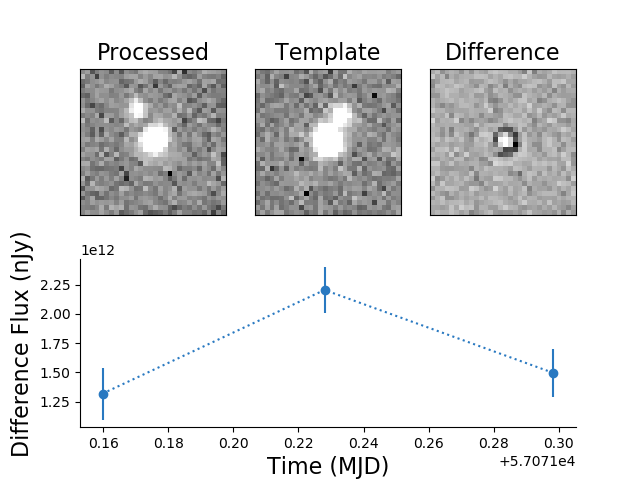

<IPython.core.display.Javascript object>


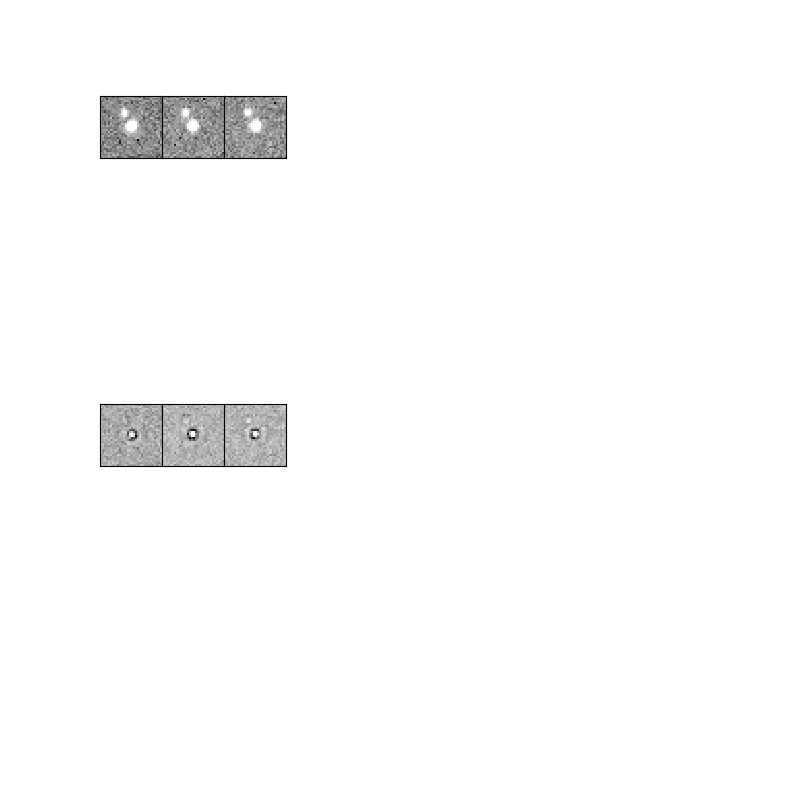

DIAObject ID: 177218094458994875
RA (deg): [155.2932482]
Dec (deg): [-5.65500367]
DIASource IDs: [177218094458994875 176493765404393975 176661269128937939
 176682743965418291 176704648298628039]
Data IDs: [{'visit': 412618, 'ccdnum': 3}, {'visit': 410931, 'ccdnum': 57}, {'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


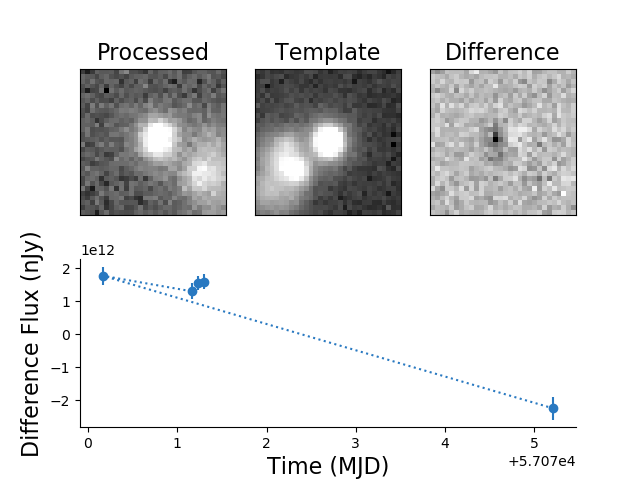

<IPython.core.display.Javascript object>


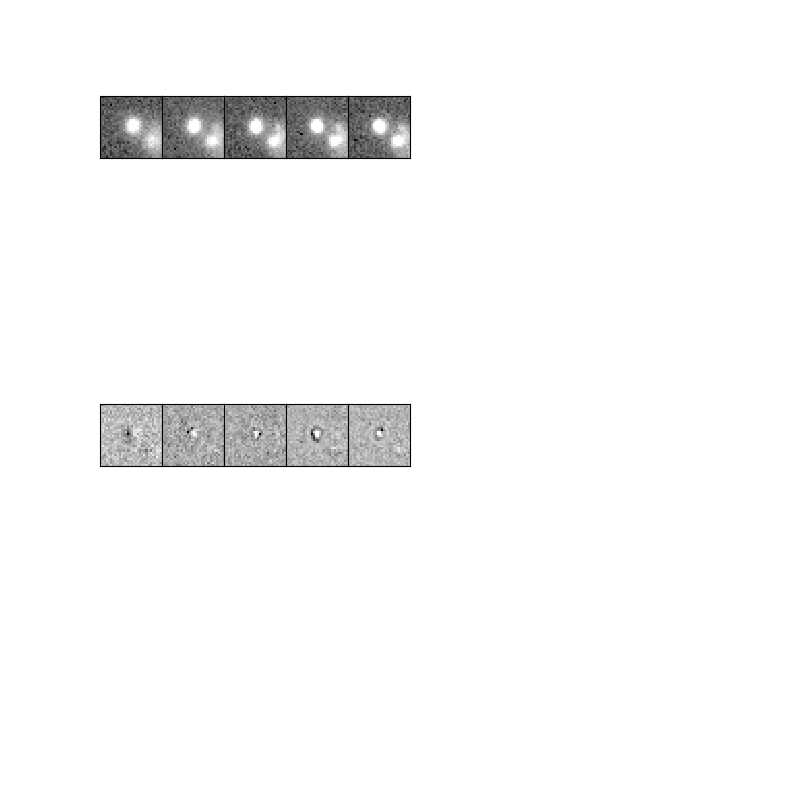

DIAObject ID: 180303598964443023
RA (deg): [155.29789667]
Dec (deg): [-5.62621592]
DIASource IDs: [180303598964443023 176682743965418296 176704648298628043]
Data IDs: [{'visit': 419802, 'ccdnum': 3}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


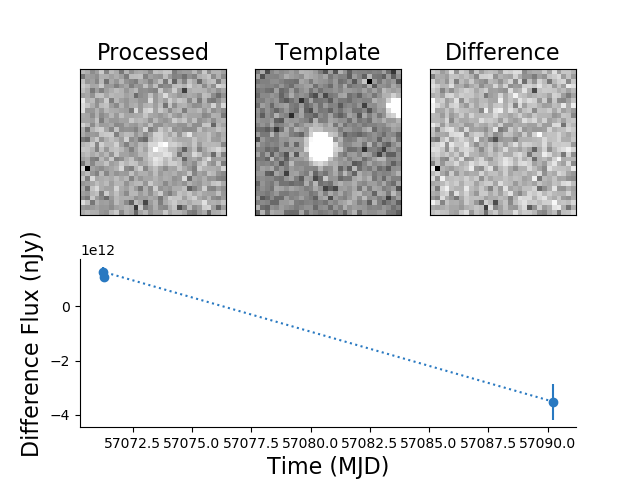

/ssd/gkovacs/lsstsw/miniconda/envs/lsst-scipipe/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


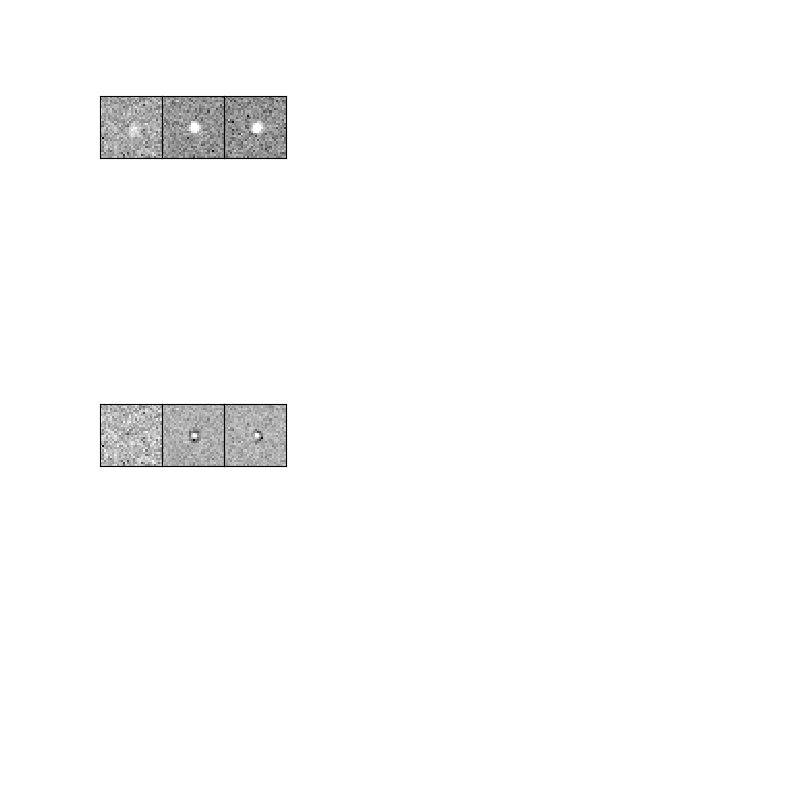

DIAObject ID: 176493765404393898
RA (deg): [155.2131683]
Dec (deg): [-5.63635567]
DIASource IDs: [176493765404393898 176661269128937873 176682743965418154
 176704648298627876 176726123135107319]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 411472, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


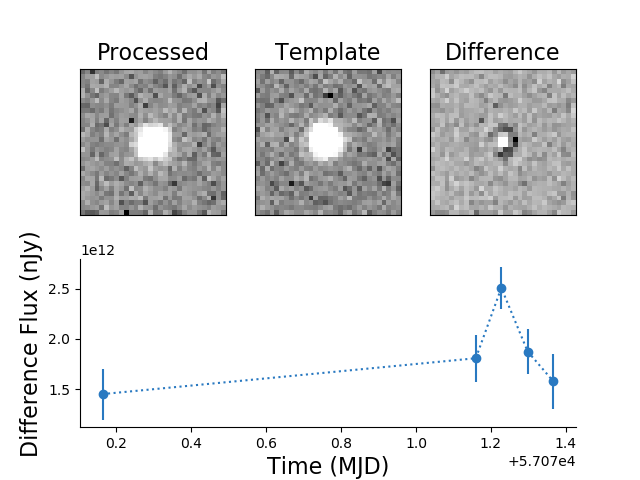

<IPython.core.display.Javascript object>


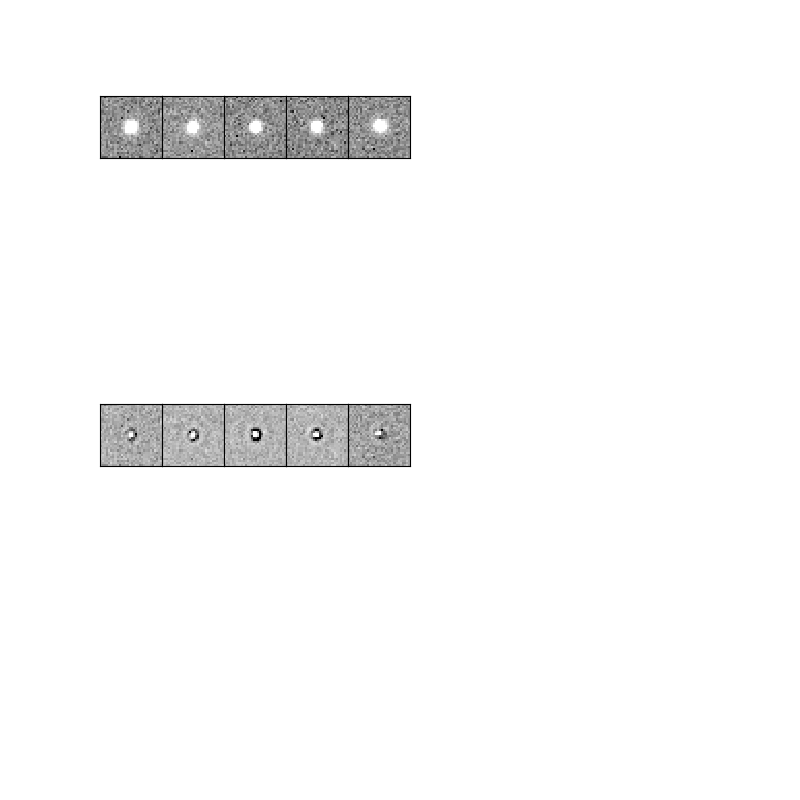

DIAObject ID: 176682743965418223
RA (deg): [155.24676665]
Dec (deg): [-5.66802088]
DIASource IDs: [176682743965418223 176704648298627961 176726123135107330]
Data IDs: [{'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 411472, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


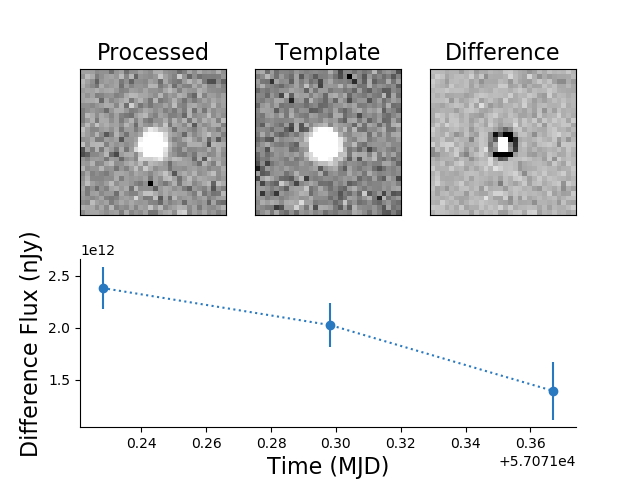

<IPython.core.display.Javascript object>


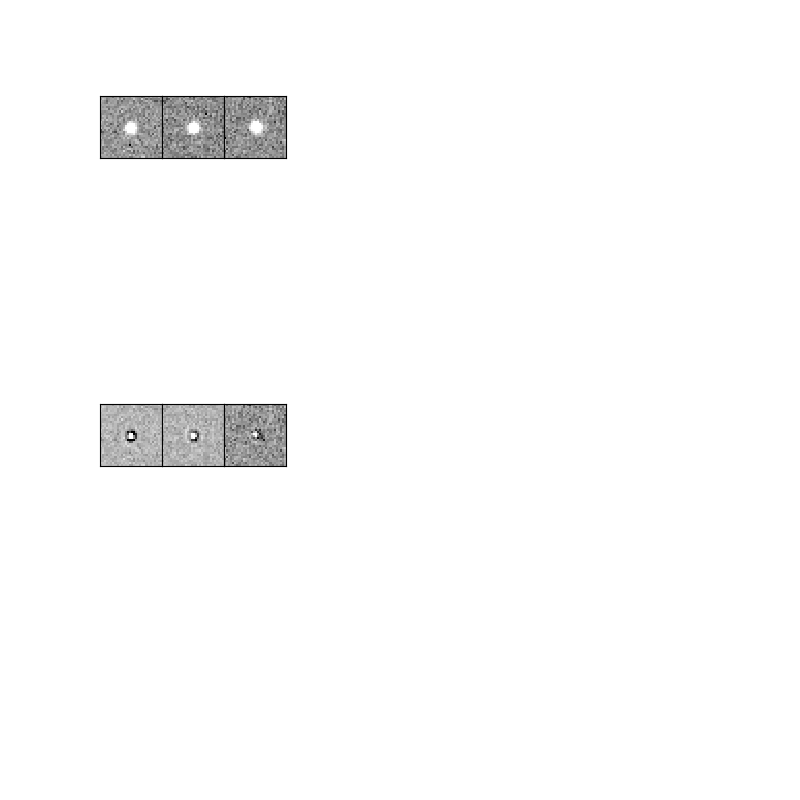

DIAObject ID: 176661269128937909
RA (deg): [155.24656403]
Dec (deg): [-5.68194775]
DIASource IDs: [176661269128937909 176682743965418222 176704648298627960
 176877305983926515]
Data IDs: [{'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 411824, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


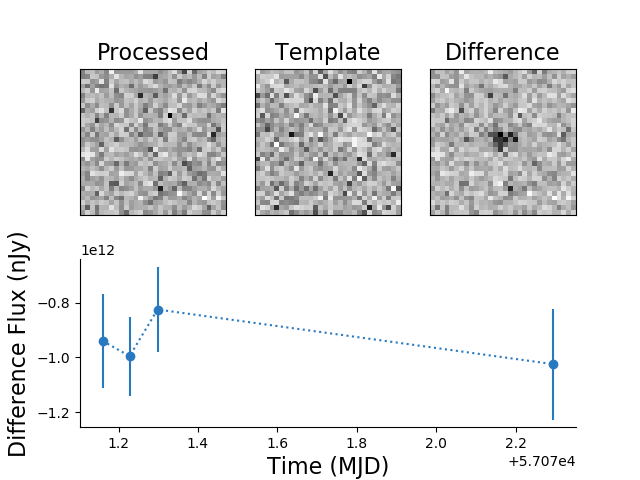

<IPython.core.display.Javascript object>


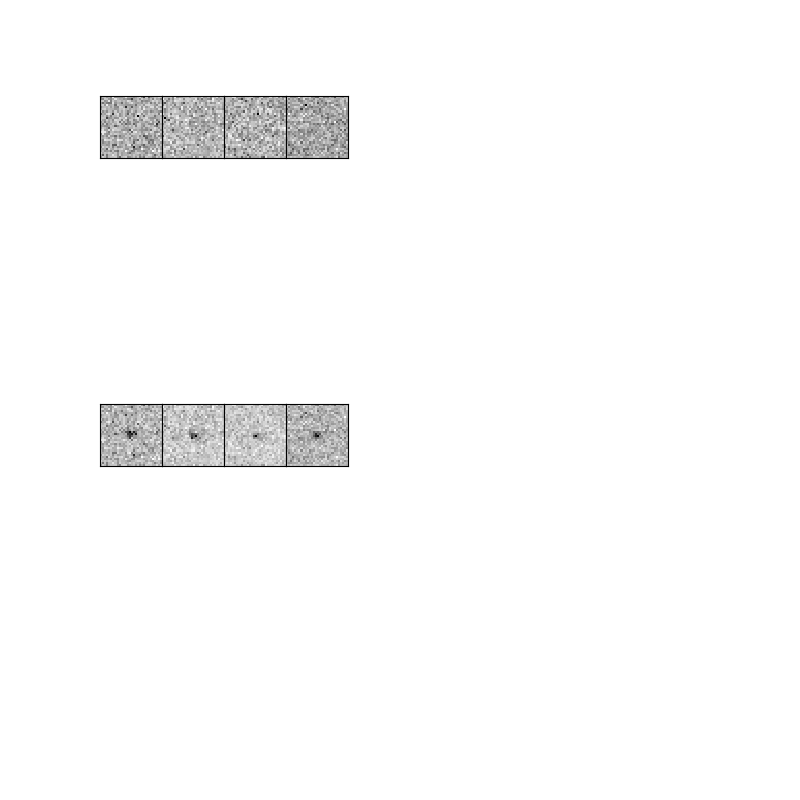

DIAObject ID: 176493765404393949
RA (deg): [155.25197714]
Dec (deg): [-5.64906306]
DIASource IDs: [176493765404393949 176639794292457737 176661269128937915
 176682743965418235 176704648298627971 176726123135107333
 176898780820406568]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 411271, 'ccdnum': 57}, {'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 411472, 'ccdnum': 57}, {'visit': 411874, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


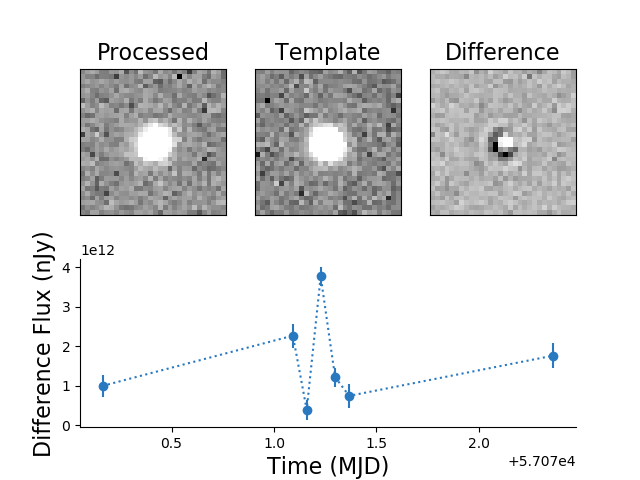

<IPython.core.display.Javascript object>


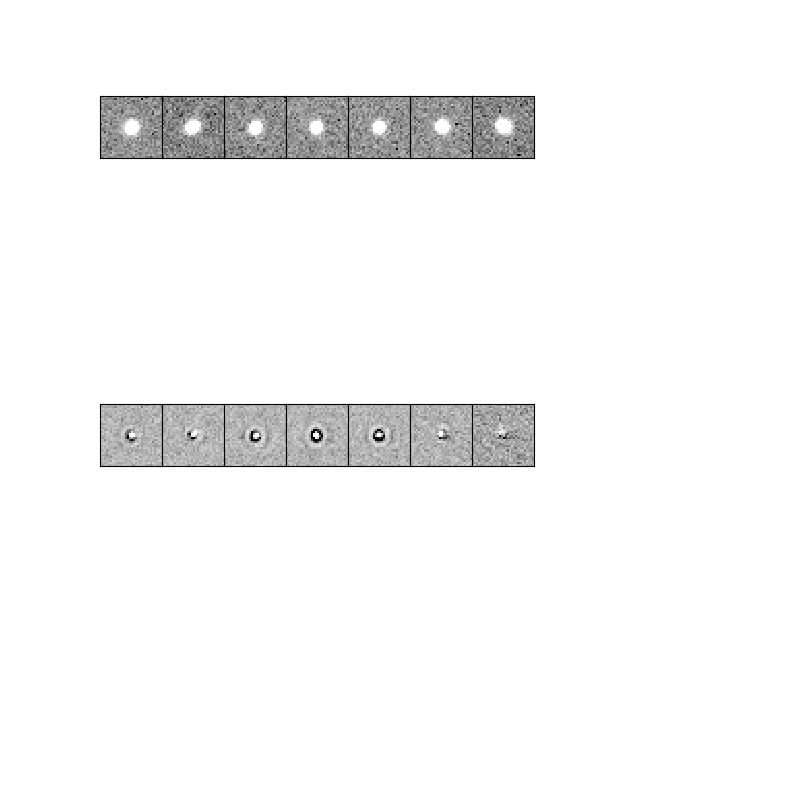

DIAObject ID: 176682743965418262
RA (deg): [155.27087585]
Dec (deg): [-5.68988946]
DIASource IDs: [176682743965418262 176704648298628009 176898780820406574]
Data IDs: [{'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 411874, 'ccdnum': 57}]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DIAObject ID: 176897702783615174
RA (deg): [155.24830349]
Dec (deg): [-5.72803172]
DIASource IDs: [176897702783615174 177218107343896731 177239582180376747
 177197710544208383]
Data IDs: [{'visit': 411872, 'ccdnum': 6}, {'visit': 412618, 'ccdnum': 6}, {'visit': 412668, 'ccdnum': 6}, {'visit': 412570, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


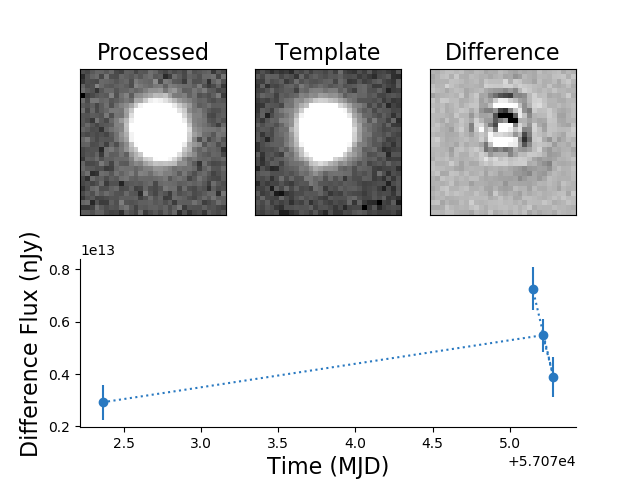

<IPython.core.display.Javascript object>


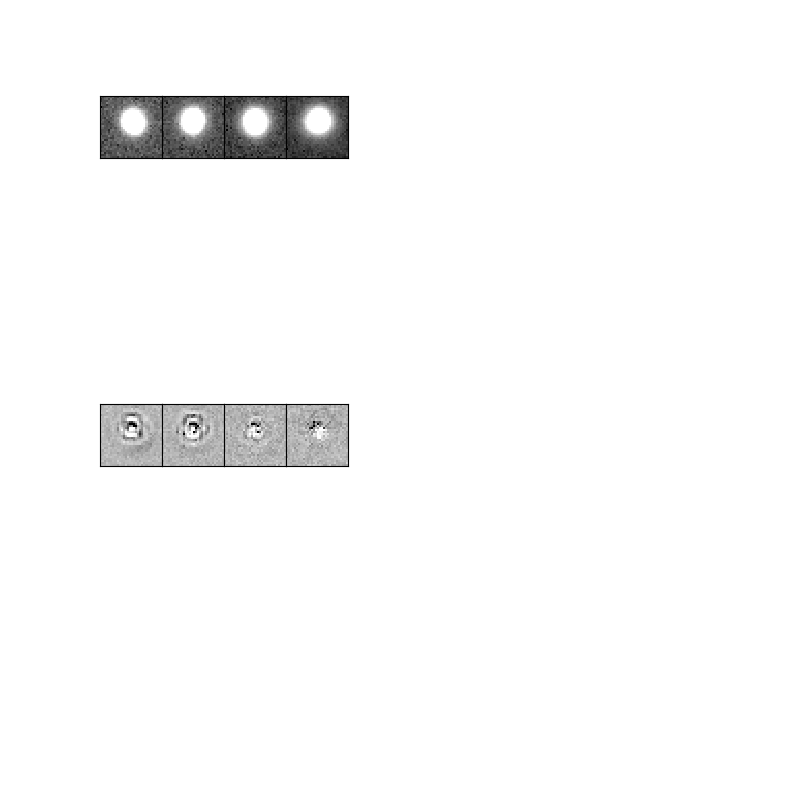

DIAObject ID: 176493765404393912
RA (deg): [155.2219763]
Dec (deg): [-5.68922063]
DIASource IDs: [176493765404393912 176682743965418170 176704648298627898
 177197710544208347 177240660217168449]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 412570, 'ccdnum': 57}, {'visit': 412670, 'ccdnum': 57}]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DIAObject ID: 176493765404393915
RA (deg): [155.22634628]
Dec (deg): [-5.68923476]
DIASource IDs: [176493765404393915 176682743965418180 176704648298627909
 177197710544208352 177240660217168458]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 412570, 'ccdnum': 57}, {'visit': 412670, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


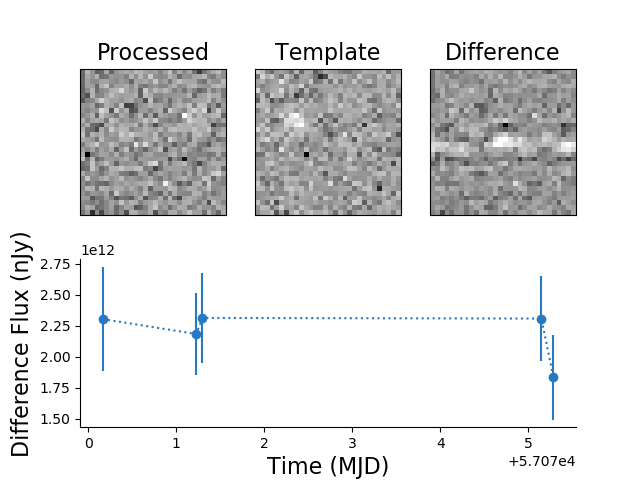

<IPython.core.display.Javascript object>


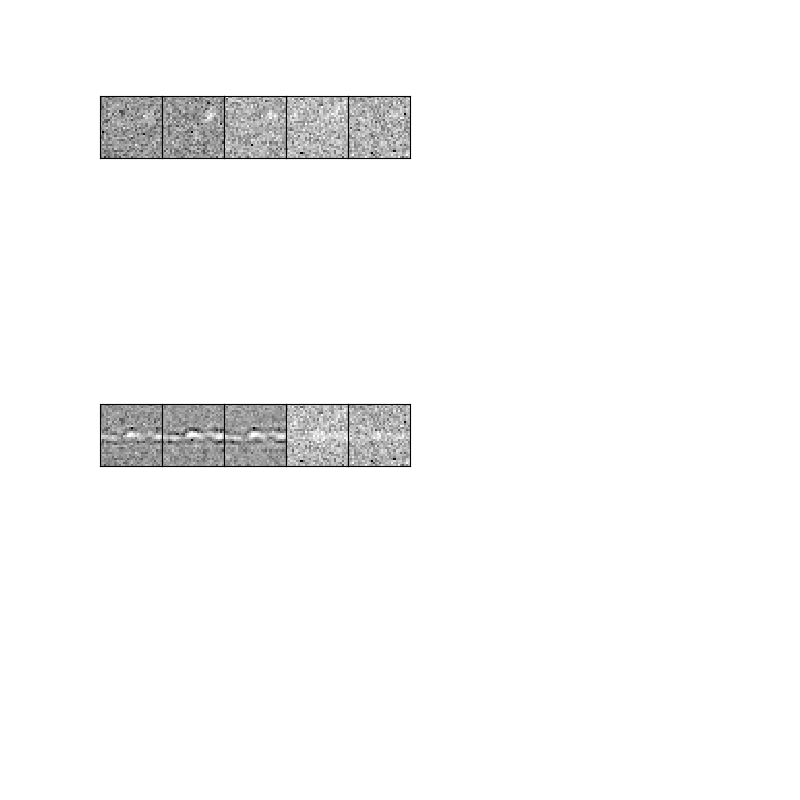

DIAObject ID: 176661269128937905
RA (deg): [155.2431263]
Dec (deg): [-5.67641875]
DIASource IDs: [176661269128937905 176682743965418213 177240660217168478]
Data IDs: [{'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 412670, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


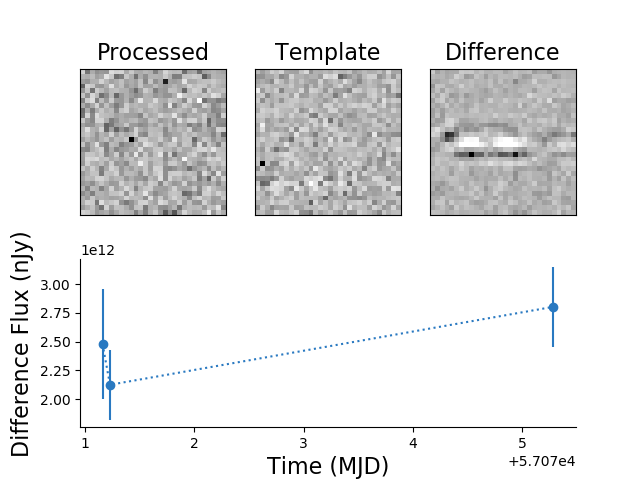

<IPython.core.display.Javascript object>


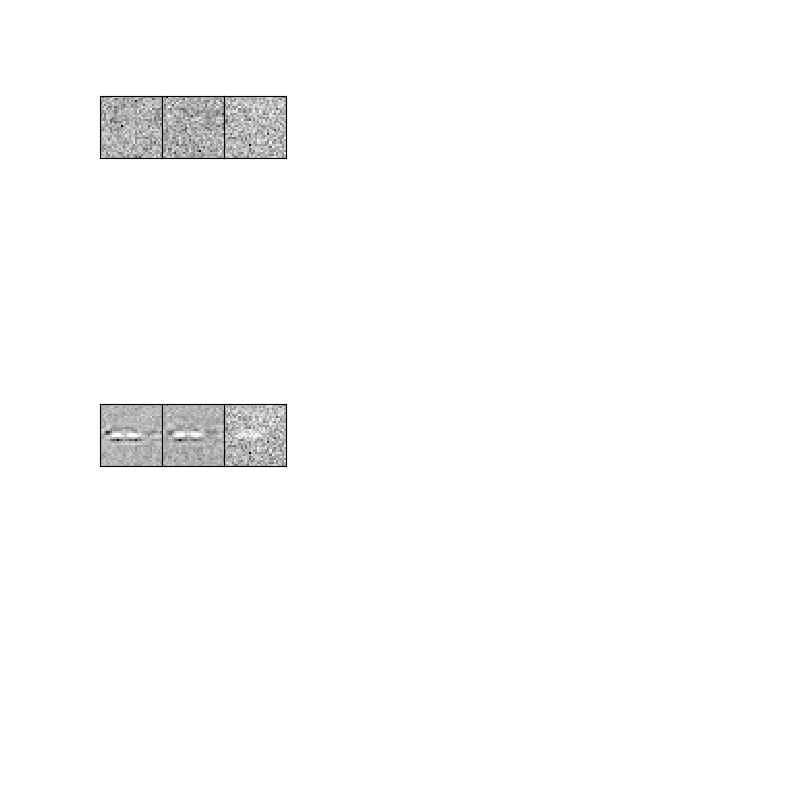

DIAObject ID: 176493765404393947
RA (deg): [155.2509126]
Dec (deg): [-5.68929113]
DIASource IDs: [176493765404393947 176682743965418233 177240660217168505]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 412670, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


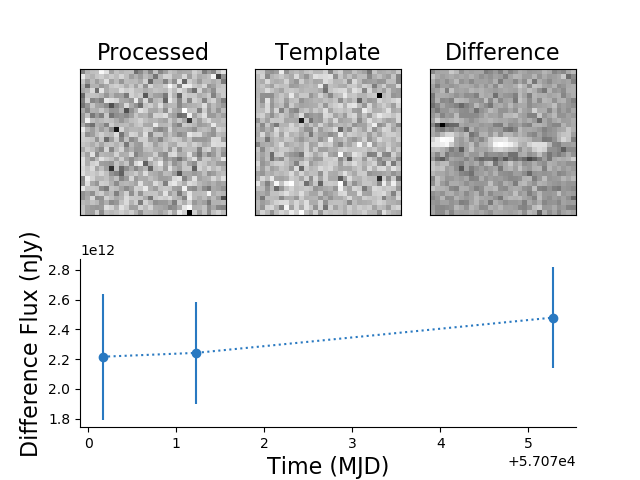

<IPython.core.display.Javascript object>

DIAObject ID: 176682743965418254
RA (deg): [155.26259997]
Dec (deg): [-5.68922359]
DIASource IDs: [176682743965418254 176704648298627995 177197710544208403
 177240660217168527]
Data IDs: [{'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 412570, 'ccdnum': 57}, {'visit': 412670, 'ccdnum': 57}]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DIAObject ID: 177197710544208361
RA (deg): [155.23255864]
Dec (deg): [-5.66253167]
DIASource IDs: [177197710544208361 177240660217168471 177262135053648295]
Data IDs: [{'visit': 412570, 'ccdnum': 57}, {'visit': 412670, 'ccdnum': 57}, {'visit': 412720, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


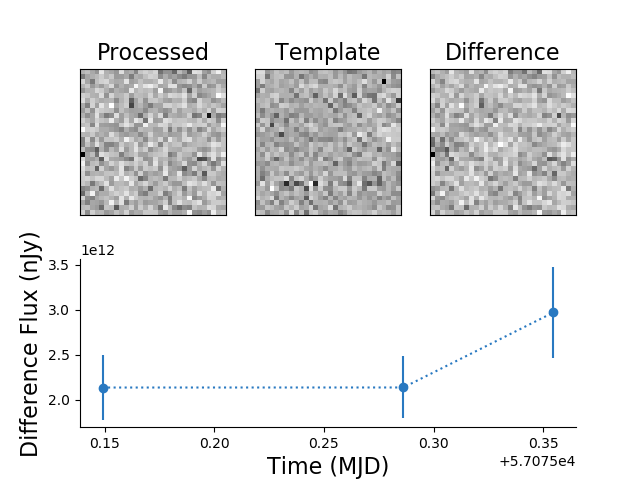

<IPython.core.display.Javascript object>


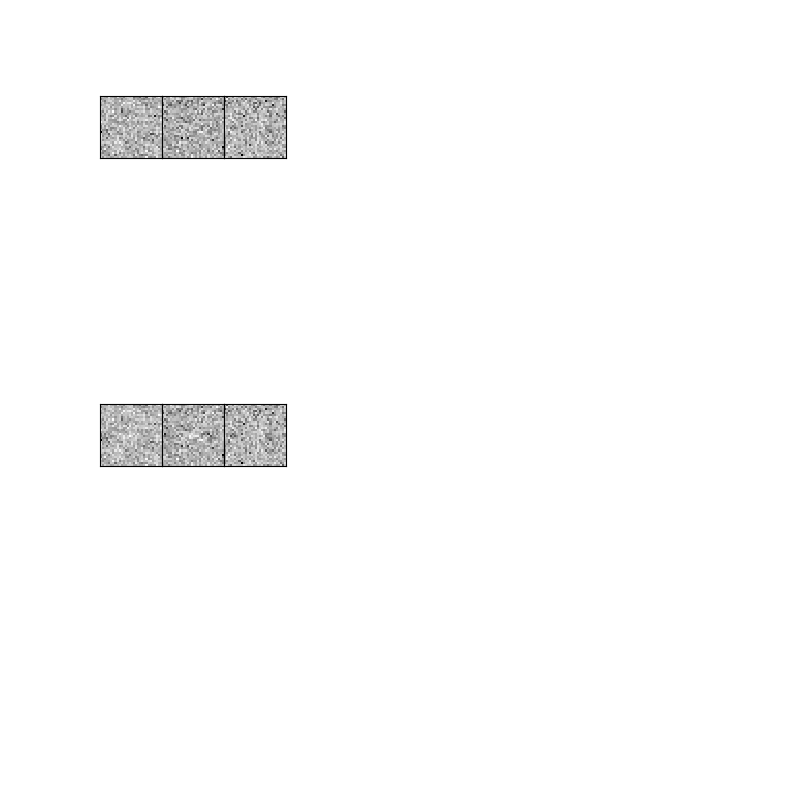

DIAObject ID: 176682743965418226
RA (deg): [155.24730189]
Dec (deg): [-5.66261818]
DIASource IDs: [176682743965418226 177240660217168501 177262135053648324]
Data IDs: [{'visit': 411371, 'ccdnum': 57}, {'visit': 412670, 'ccdnum': 57}, {'visit': 412720, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


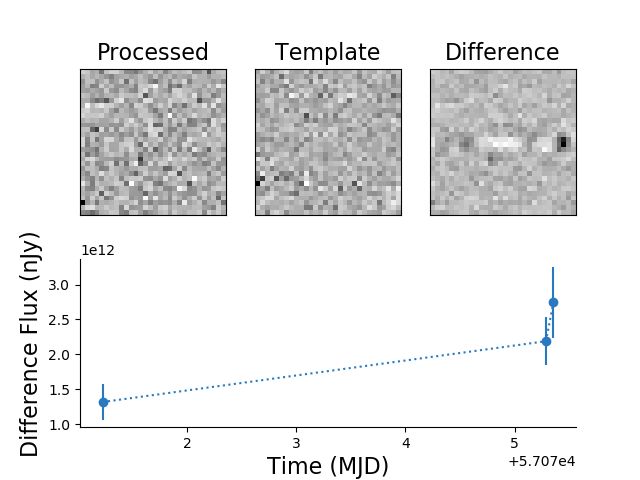

<IPython.core.display.Javascript object>


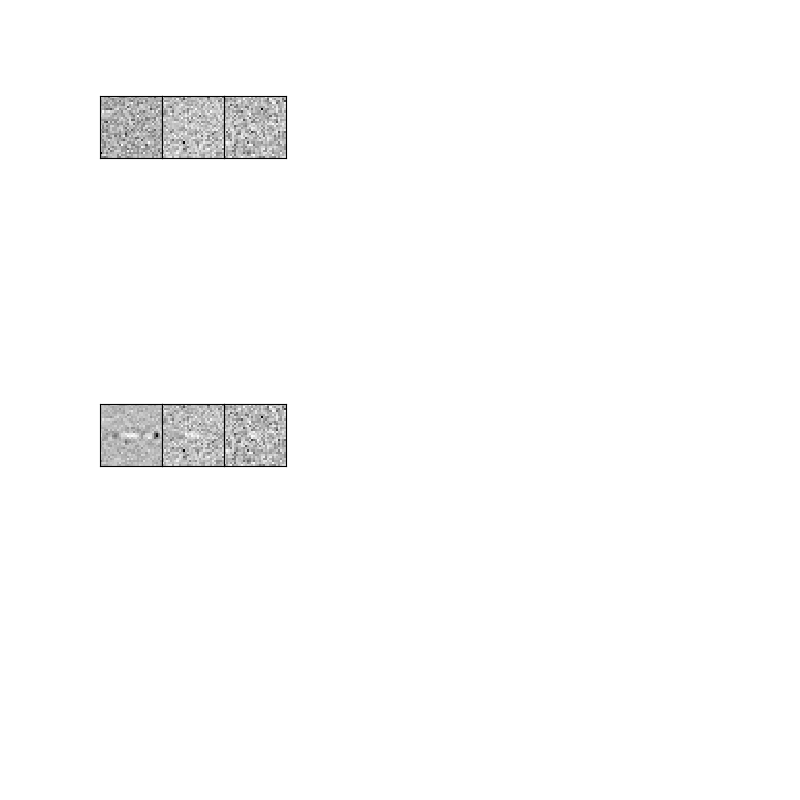

DIAObject ID: 176682743965418266
RA (deg): [155.27322402]
Dec (deg): [-5.68931657]
DIASource IDs: [176682743965418266 176704648298628015 177240660217168541
 177262135053648373]
Data IDs: [{'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 412670, 'ccdnum': 57}, {'visit': 412720, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


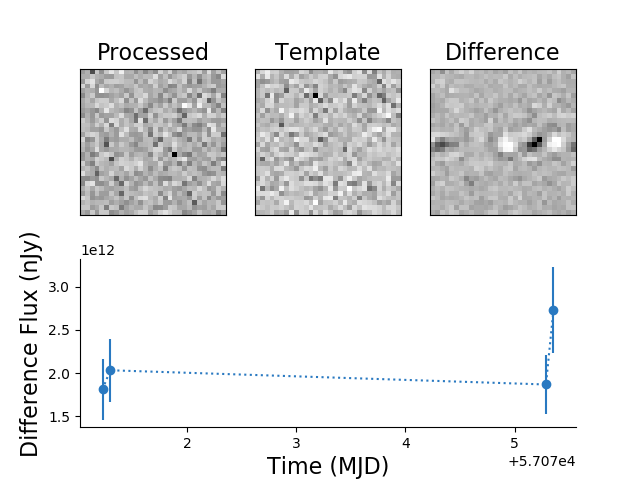

<IPython.core.display.Javascript object>


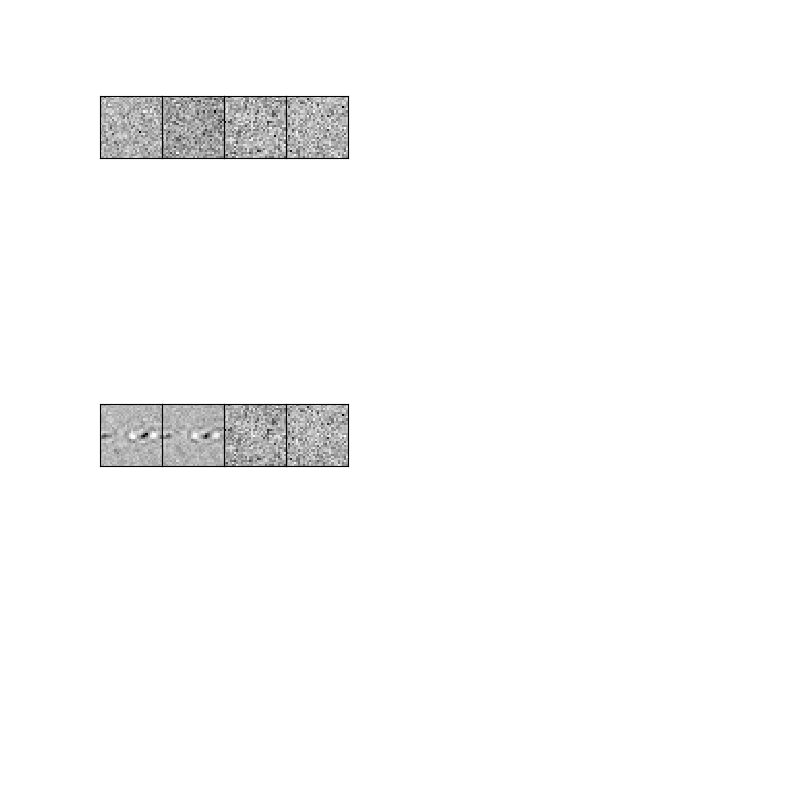

DIAObject ID: 176539292057731258
RA (deg): [155.24243688]
Dec (deg): [-5.6813884]
DIASource IDs: [176539292057731258 177176235707728296 177681323861737673]
Data IDs: [{'visit': 411037, 'ccdnum': 57}, {'visit': 412520, 'ccdnum': 57}, {'visit': 413696, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


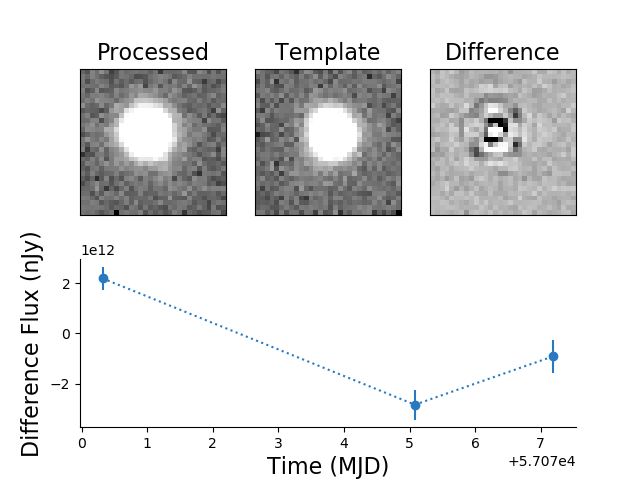

<IPython.core.display.Javascript object>

DIAObject ID: 177066065501618299
RA (deg): [155.24861788]
Dec (deg): [-5.72801312]
DIASource IDs: [177066065501618299 177196632507416721 178383121517904239]
Data IDs: [{'visit': 412264, 'ccdnum': 6}, {'visit': 412568, 'ccdnum': 6}, {'visit': 415330, 'ccdnum': 57}]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


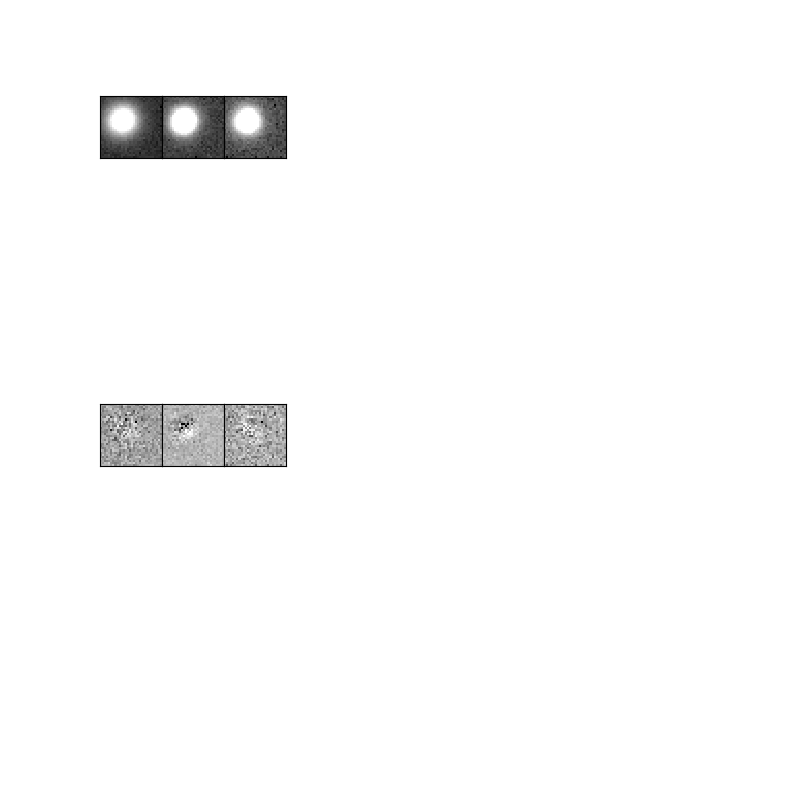

DIAObject ID: 176493765404393936
RA (deg): [155.24245438]
Dec (deg): [-5.68968214]
DIASource IDs: [176493765404393936 176682743965418215 176704648298627947
 177176235707728295 177240660217168487 177262135053648307
 178383121517904233 178404596354384220]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 412520, 'ccdnum': 57}, {'visit': 412670, 'ccdnum': 57}, {'visit': 412720, 'ccdnum': 57}, {'visit': 415330, 'ccdnum': 57}, {'visit': 415380, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


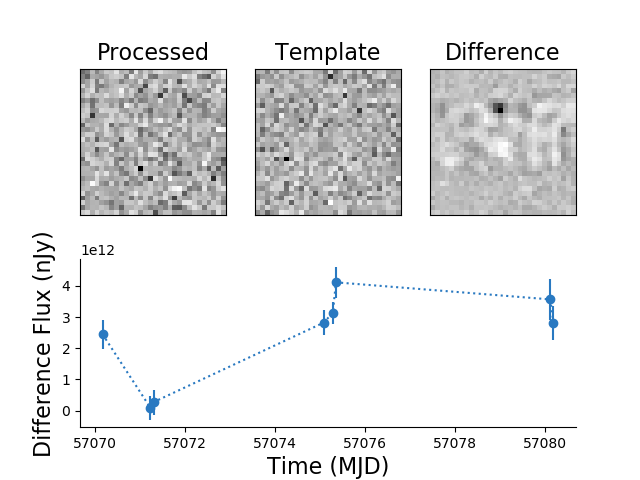

<IPython.core.display.Javascript object>


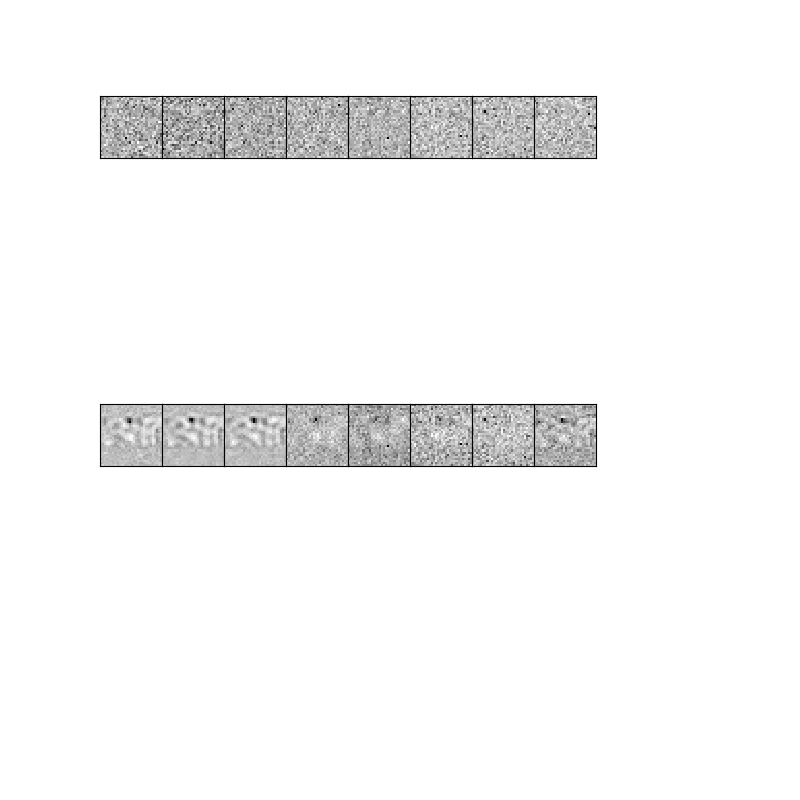

DIAObject ID: 176493765404393938
RA (deg): [155.24432682]
Dec (deg): [-5.68931453]
DIASource IDs: [176493765404393938 176682743965418218 176704648298627952
 178404596354384221]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 415380, 'ccdnum': 57}]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DIAObject ID: 176704648298627967
RA (deg): [155.24997123]
Dec (deg): [-5.68925574]
DIASource IDs: [176704648298627967 177176235707728304 177197710544208386
 177262135053648329 178404596354384225]
Data IDs: [{'visit': 411422, 'ccdnum': 57}, {'visit': 412520, 'ccdnum': 57}, {'visit': 412570, 'ccdnum': 57}, {'visit': 412720, 'ccdnum': 57}, {'visit': 415380, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


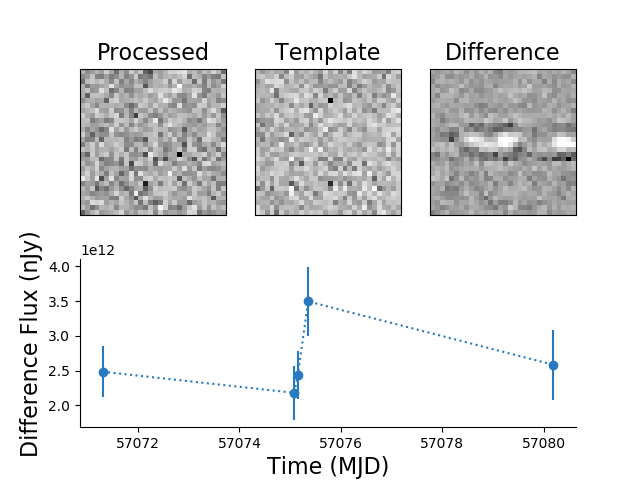

<IPython.core.display.Javascript object>


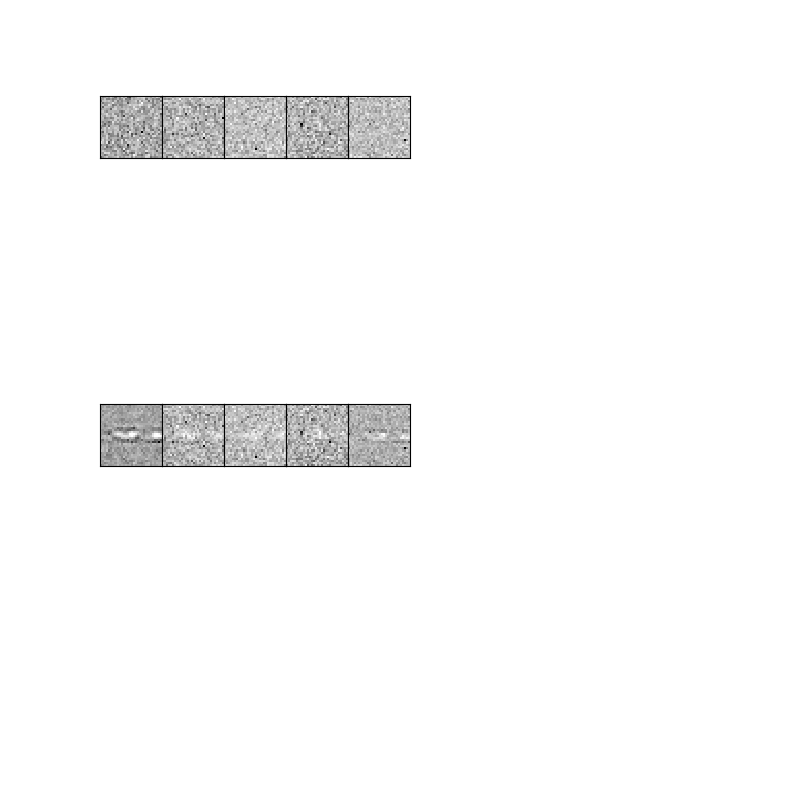

DIAObject ID: 176493765404393940
RA (deg): [155.24572006]
Dec (deg): [-5.62959185]
DIASource IDs: [176493765404393940 176517817221251323 176539292057731259
 176553894946537712 176639794292457735 176661269128937907
 176682743965418221 176704648298627956 176726123135107329
 176812451977756851 176877305983926514 176898780820406565
 178404596354384222 180304689886134499]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 410987, 'ccdnum': 57}, {'visit': 411037, 'ccdnum': 57}, {'visit': 411071, 'ccdnum': 57}, {'visit': 411271, 'ccdnum': 57}, {'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 411472, 'ccdnum': 57}, {'visit': 411673, 'ccdnum': 57}, {'visit': 411824, 'ccdnum': 57}, {'visit': 411874, 'ccdnum': 57}, {'visit': 415380, 'ccdnum': 57}, {'visit': 419804, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


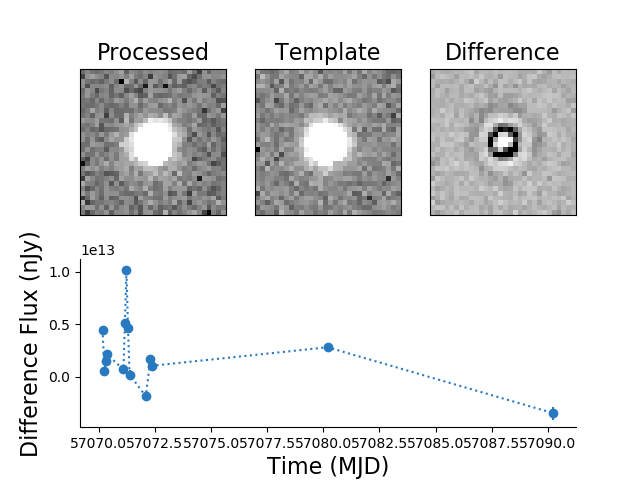

<IPython.core.display.Javascript object>


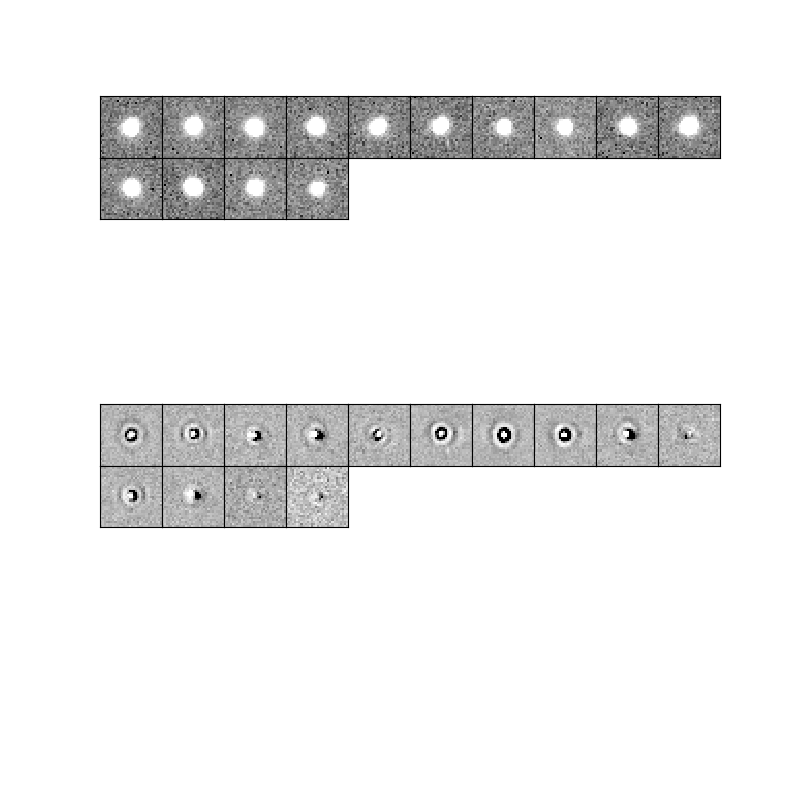

DIAObject ID: 176493765404393907
RA (deg): [155.221096]
Dec (deg): [-5.64023722]
DIASource IDs: [176493765404393907 176517817221251316 176539292057731254
 176553894946537706 176639794292457727 176661269128937884
 176682743965418165 176704648298627893 176726123135107322
 176812451977756845 176834356310966521 176855831147446460
 176877305983926508 176898780820406558 176985539159785677
 177176235707728269 177197710544208344 177240660217168446
 177661996508905670 177681323861737669 178404596354384208
 180304689886134490 181078642992873784]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 410987, 'ccdnum': 57}, {'visit': 411037, 'ccdnum': 57}, {'visit': 411071, 'ccdnum': 57}, {'visit': 411271, 'ccdnum': 57}, {'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 411472, 'ccdnum': 57}, {'visit': 411673, 'ccdnum': 57}, {'visit': 411724, 'ccdnum': 57}, {'visit': 411774, 'ccdnum': 57}, {'visit': 411824, 'ccdnum': 57}, {'visit': 411874, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


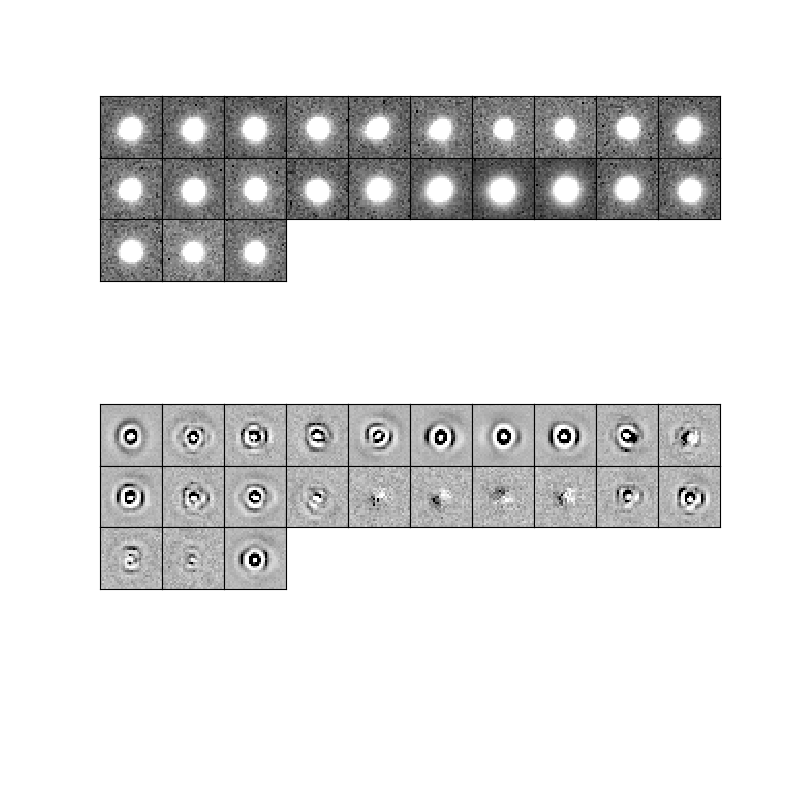

DIAObject ID: 176493765404393943
RA (deg): [155.24728007]
Dec (deg): [-5.67636702]
DIASource IDs: [176493765404393943 176661269128937911 176682743965418225
 176704648298627963 181078642992873796]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 421606, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


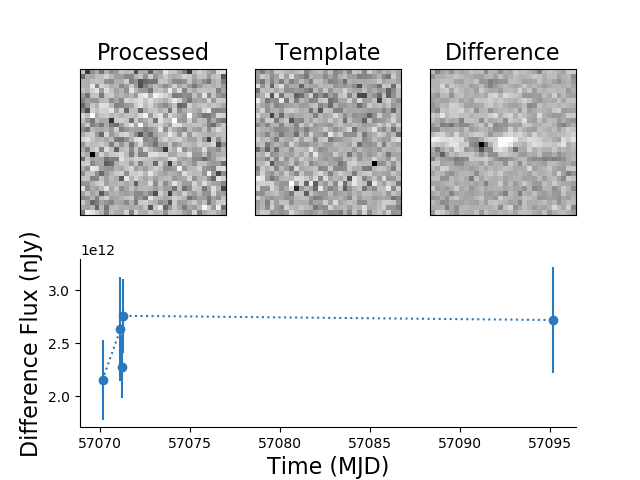

<IPython.core.display.Javascript object>


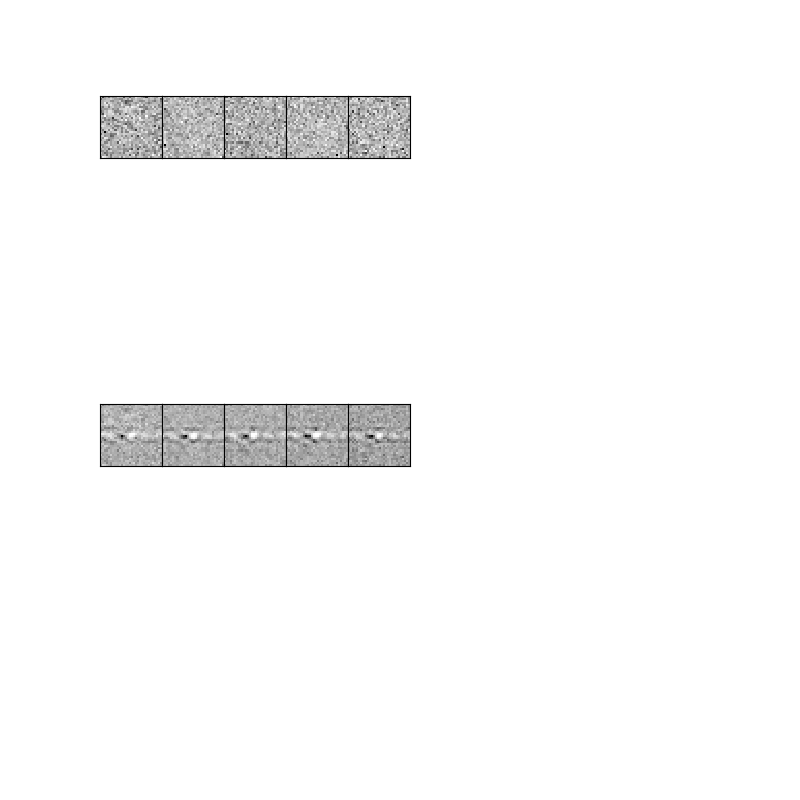

DIAObject ID: 176493765404393948
RA (deg): [155.25169595]
Dec (deg): [-5.62864922]
DIASource IDs: [176493765404393948 176517817221251326 176553894946537714
 176661269128937914 176682743965418234 176704648298627970
 176726123135107332 176877305983926518 176898780820406567
 181078642992873799]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 410987, 'ccdnum': 57}, {'visit': 411071, 'ccdnum': 57}, {'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 411472, 'ccdnum': 57}, {'visit': 411824, 'ccdnum': 57}, {'visit': 411874, 'ccdnum': 57}, {'visit': 421606, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


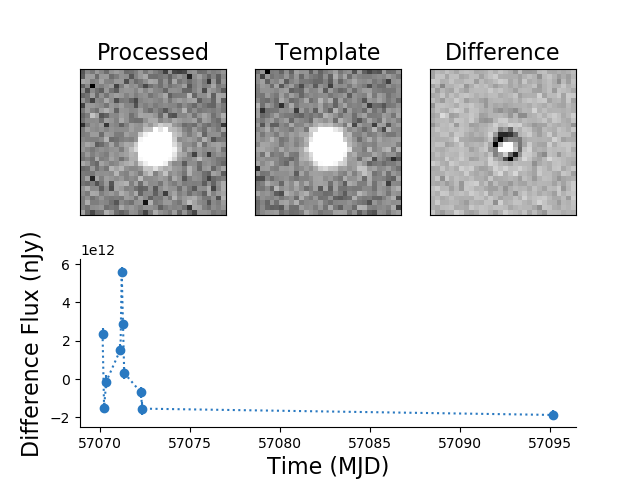

<IPython.core.display.Javascript object>


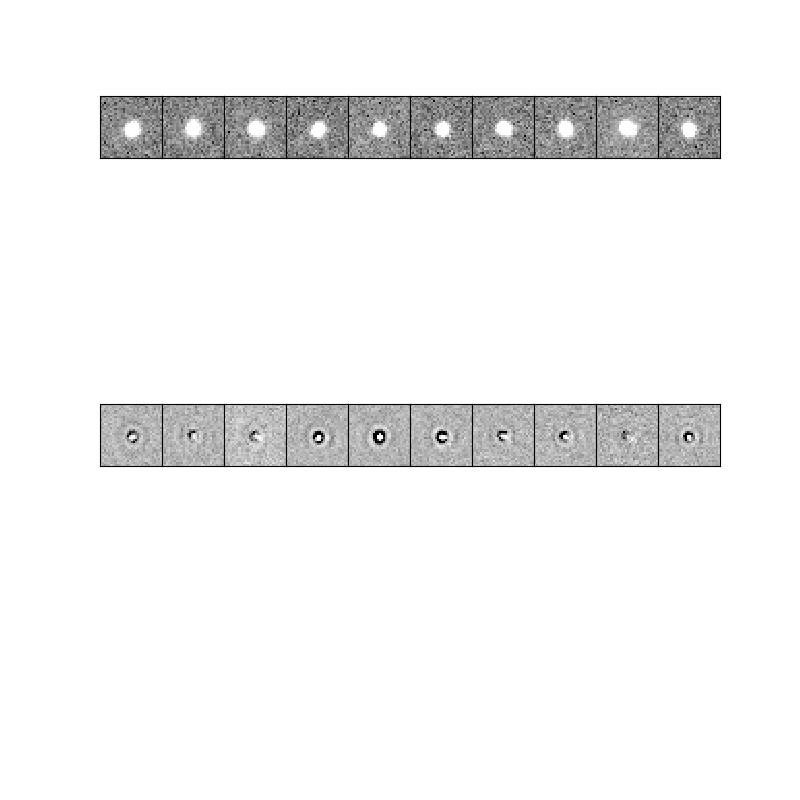

DIAObject ID: 176493765404393952
RA (deg): [155.2577368]
Dec (deg): [-5.66267721]
DIASource IDs: [176493765404393952 176661269128937918 181078642992873800]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 411321, 'ccdnum': 57}, {'visit': 421606, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


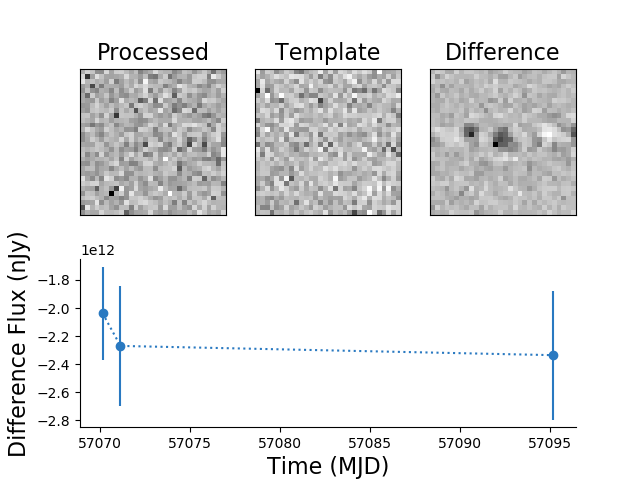

<IPython.core.display.Javascript object>


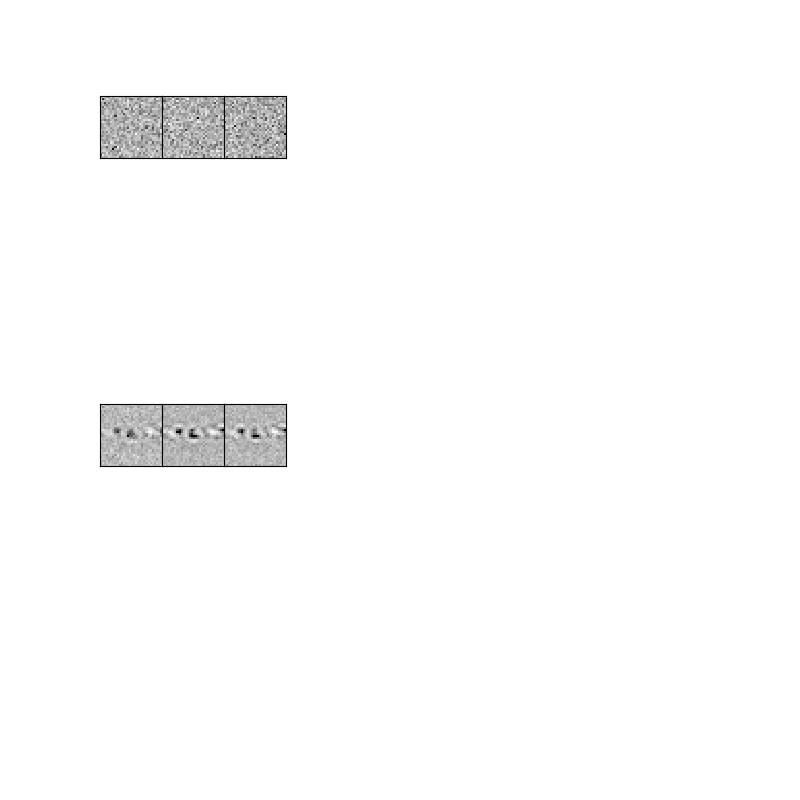

DIAObject ID: 176638716255666408
RA (deg): [155.25870717]
Dec (deg): [-5.72767988]
DIASource IDs: [176638716255666408 176725045098316020 176553894946537718
 176639794292457739 176661269128937922 176682743965418247
 176704648298627986 176726123135107336 181078642992873804]
Data IDs: [{'visit': 411269, 'ccdnum': 6}, {'visit': 411470, 'ccdnum': 6}, {'visit': 411071, 'ccdnum': 57}, {'visit': 411271, 'ccdnum': 57}, {'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 411472, 'ccdnum': 57}, {'visit': 421606, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


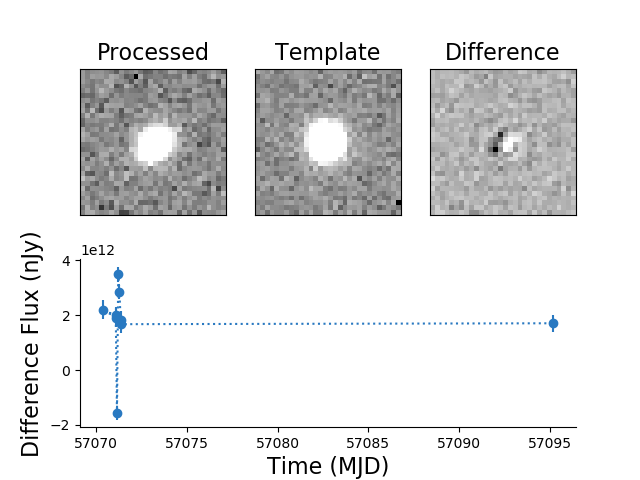

<IPython.core.display.Javascript object>


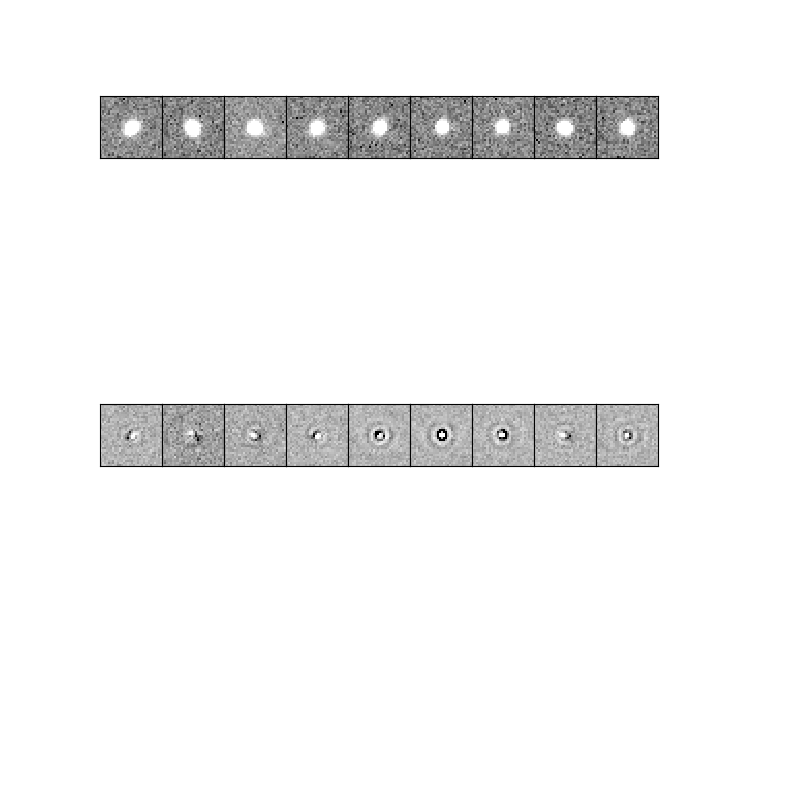

DIAObject ID: 176493765404393955
RA (deg): [155.26028734]
Dec (deg): [-5.64969846]
DIASource IDs: [176493765404393955 176517817221251329 176539292057731264
 176553894946537720 176639794292457741 176661269128937923
 176682743965418249 176704648298627988 176726123135107338
 176812451977756855 176834356310966531 176855831147446469
 176877305983926522 176898780820406572 177176235707728312
 177197710544208399 177219185380688074 177240660217168520
 177262135053648354 177661996508905682 177681323861737678
 178404596354384230 181078642992873805]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 410987, 'ccdnum': 57}, {'visit': 411037, 'ccdnum': 57}, {'visit': 411071, 'ccdnum': 57}, {'visit': 411271, 'ccdnum': 57}, {'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 411472, 'ccdnum': 57}, {'visit': 411673, 'ccdnum': 57}, {'visit': 411724, 'ccdnum': 57}, {'visit': 411774, 'ccdnum': 57}, {'visit': 411824, 'ccdnum': 57}, {'visit': 411874

<IPython.core.display.Javascript object>


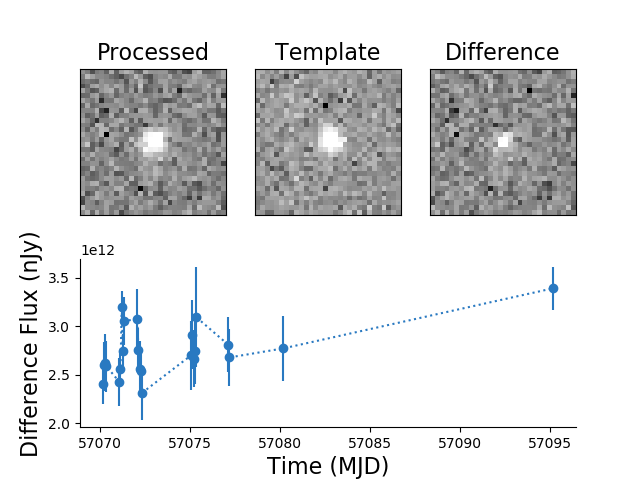

<IPython.core.display.Javascript object>


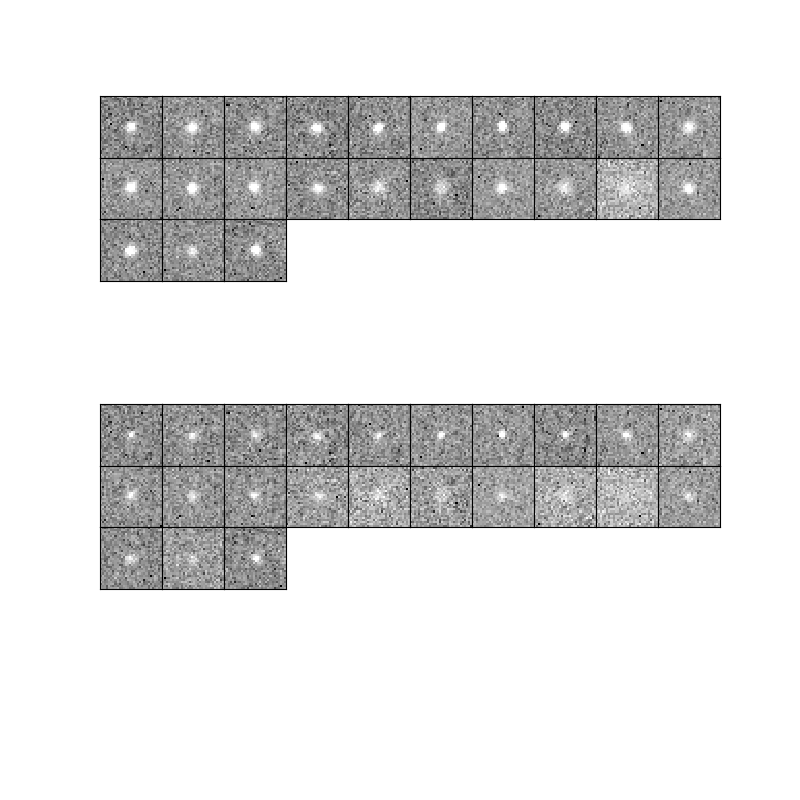

DIAObject ID: 176493765404393962
RA (deg): [155.27247899]
Dec (deg): [-5.67600671]
DIASource IDs: [176493765404393962 176661269128937930 176682743965418265
 176704648298628012 176877305983926524 181078642992873808]
Data IDs: [{'visit': 410931, 'ccdnum': 57}, {'visit': 411321, 'ccdnum': 57}, {'visit': 411371, 'ccdnum': 57}, {'visit': 411422, 'ccdnum': 57}, {'visit': 411824, 'ccdnum': 57}, {'visit': 421606, 'ccdnum': 57}]


<IPython.core.display.Javascript object>


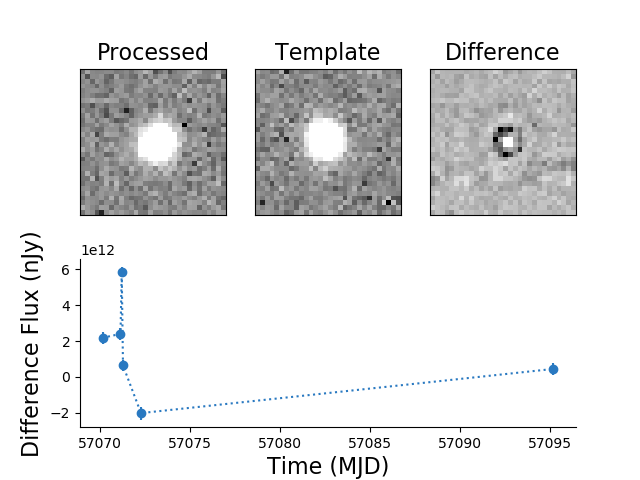

<IPython.core.display.Javascript object>


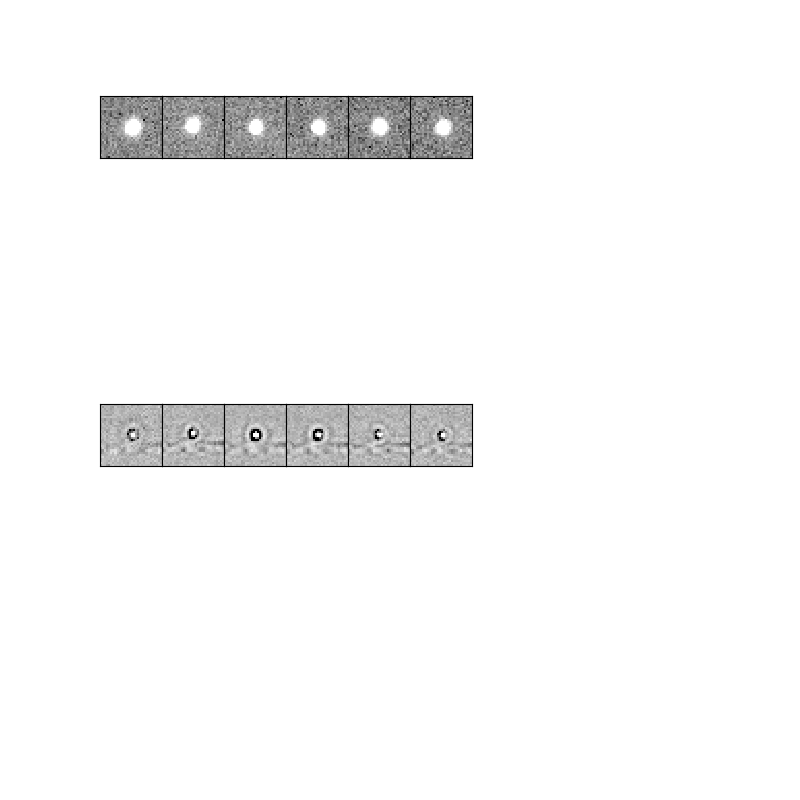

DIAObject ID: 176552804024844478
RA (deg): [155.29668491]
Dec (deg): [-5.65077967]
DIASource IDs: [176552804024844478 176638703370764496 176660178207244462
 176681653043724493 176703557376934082 176725032213414087
 176811361056063612 176832835892543636 176876215062233245
 176897689898713300 177090533930303753 177175144786034967
 177196619622514923 177218094458994877 177239569295474894
 177660905587212511 177680232940044410 178382030596211251
 180303598964443011 176493765404393976 176539292057731273
 176553894946537729 176639794292457753 176661269128937940
 176682743965418293 176704648298628042 176726123135107348
 176812451977756862 176834356310966539 176877305983926533
 176898780820406582 176985539159785701 177176235707728328
 177240660217168552 177262135053648387 181078642992873815]
Data IDs: [{'visit': 411069, 'ccdnum': 3}, {'visit': 411269, 'ccdnum': 3}, {'visit': 411319, 'ccdnum': 3}, {'visit': 411369, 'ccdnum': 3}, {'visit': 411420, 'ccdnum': 3}, {'visit': 411470, 'ccdnum': 3}, {'

<IPython.core.display.Javascript object>


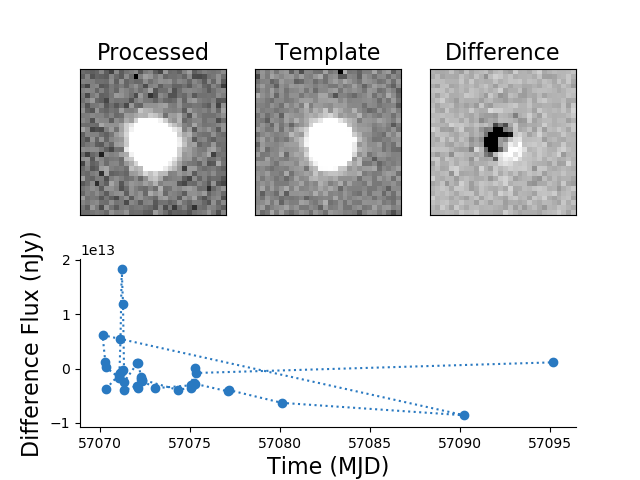

<IPython.core.display.Javascript object>


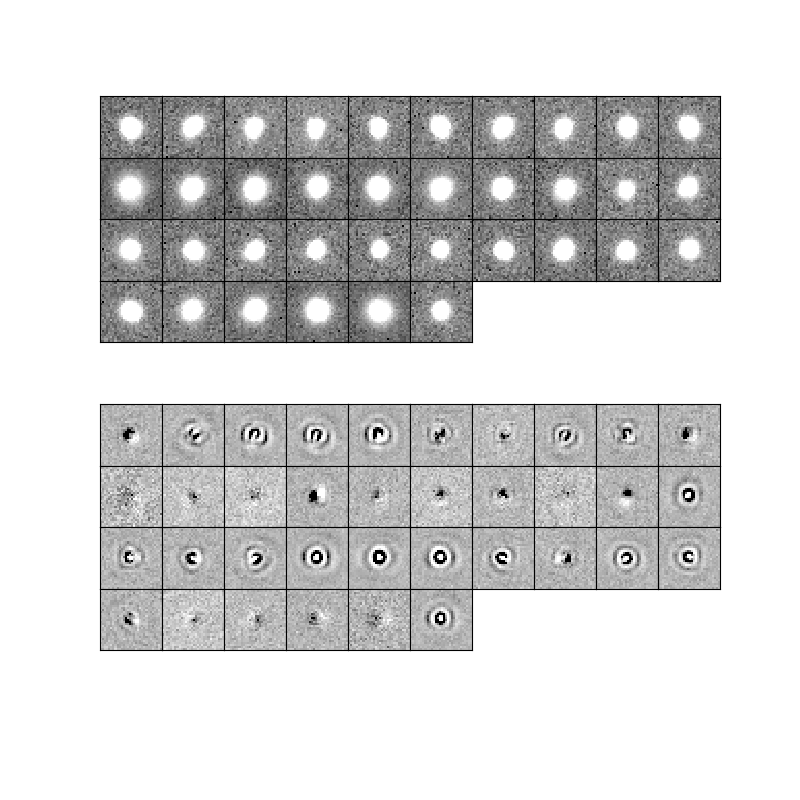

DIAObject ID: 176681665928626404
RA (deg): [155.28134148]
Dec (deg): [-5.7961033]
DIASource IDs: [176681665928626404 181077564956082386 176539304942633215
 176661282013839627 176812464862658727]
Data IDs: [{'visit': 411369, 'ccdnum': 6}, {'visit': 421604, 'ccdnum': 6}, {'visit': 411037, 'ccdnum': 60}, {'visit': 411321, 'ccdnum': 60}, {'visit': 411673, 'ccdnum': 60}]


<IPython.core.display.Javascript object>


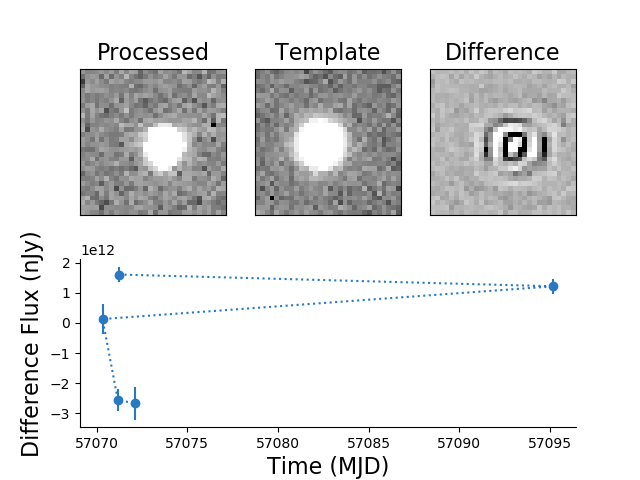

<IPython.core.display.Javascript object>


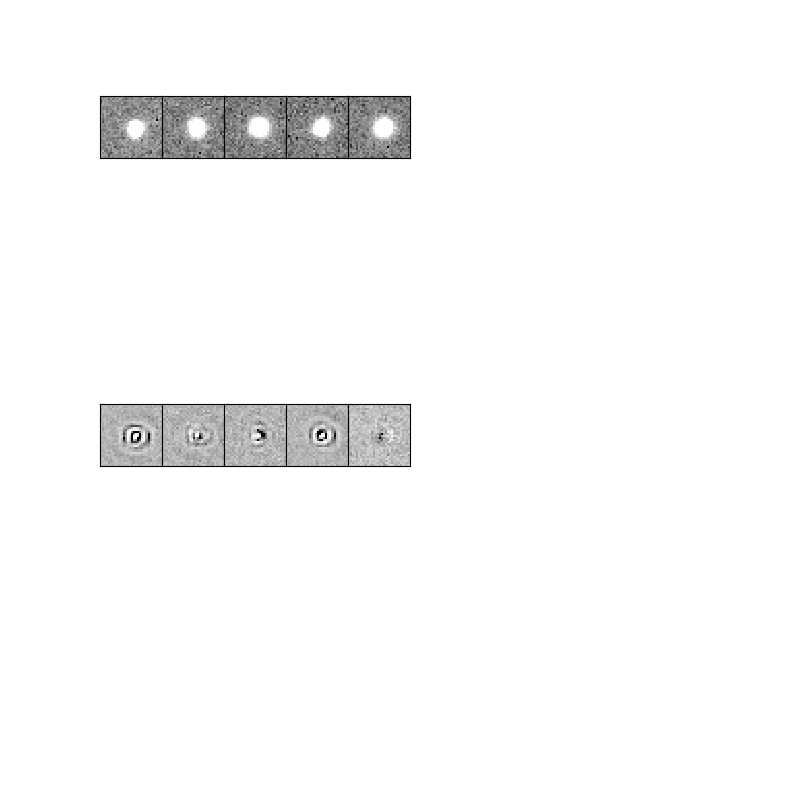

DIAObject ID: 176682756850319667
RA (deg): [155.28157739]
Dec (deg): [-5.79607545]
DIASource IDs: [176682756850319667 176704661183529267 176877318868828417
 177681336746639550]
Data IDs: [{'visit': 411371, 'ccdnum': 60}, {'visit': 411422, 'ccdnum': 60}, {'visit': 411824, 'ccdnum': 60}, {'visit': 413696, 'ccdnum': 60}]


<IPython.core.display.Javascript object>


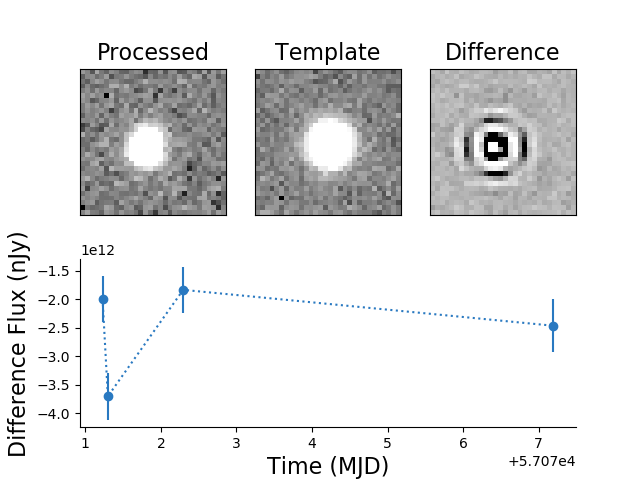

<IPython.core.display.Javascript object>


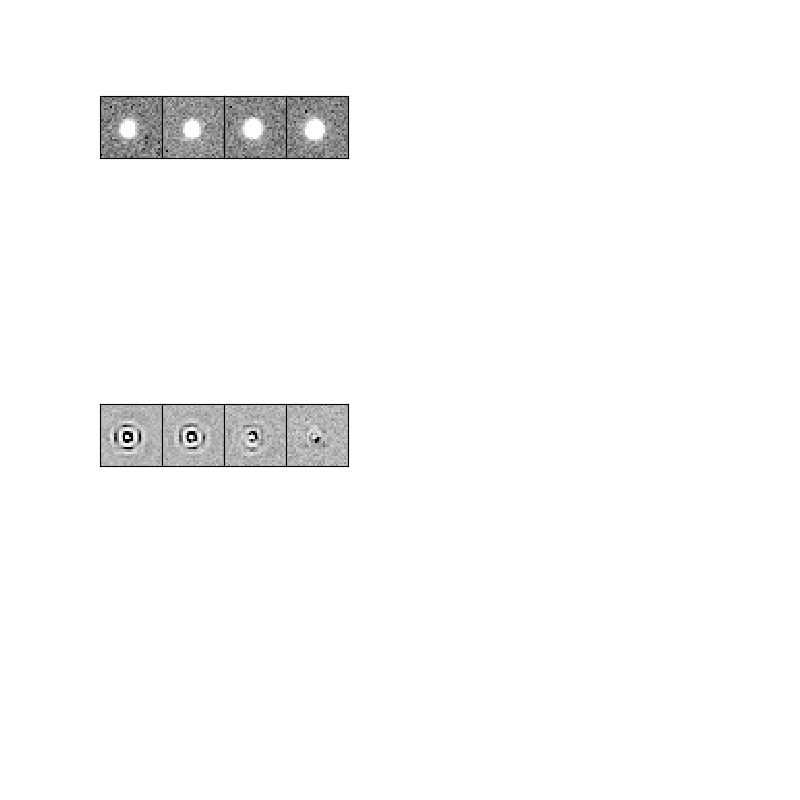

DIAObject ID: 176811373940965605
RA (deg): [155.25382584]
Dec (deg): [-5.79303021]
DIASource IDs: [176811373940965605 176493778289295582 176539304942633209
 176639807177359595 176661282013839620 176682756850319660
 176704661183529262 176726136020009224 176834369195868381
 176877318868828410 176898793705308392 177176248592629944
 181078655877775626]
Data IDs: [{'visit': 411671, 'ccdnum': 6}, {'visit': 410931, 'ccdnum': 60}, {'visit': 411037, 'ccdnum': 60}, {'visit': 411271, 'ccdnum': 60}, {'visit': 411321, 'ccdnum': 60}, {'visit': 411371, 'ccdnum': 60}, {'visit': 411422, 'ccdnum': 60}, {'visit': 411472, 'ccdnum': 60}, {'visit': 411724, 'ccdnum': 60}, {'visit': 411824, 'ccdnum': 60}, {'visit': 411874, 'ccdnum': 60}, {'visit': 412520, 'ccdnum': 60}, {'visit': 421606, 'ccdnum': 60}]


<IPython.core.display.Javascript object>


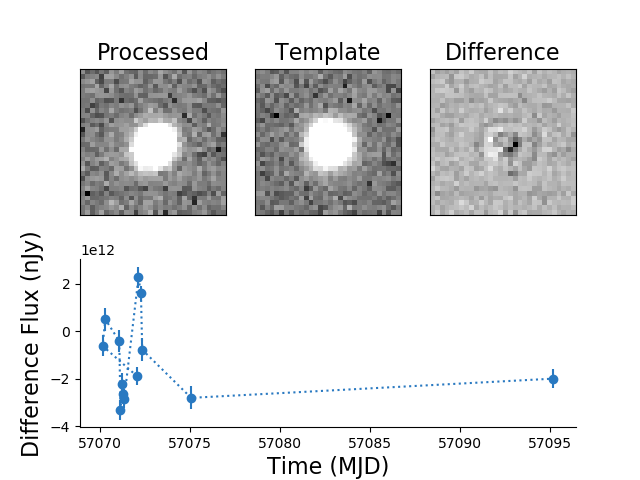

<IPython.core.display.Javascript object>


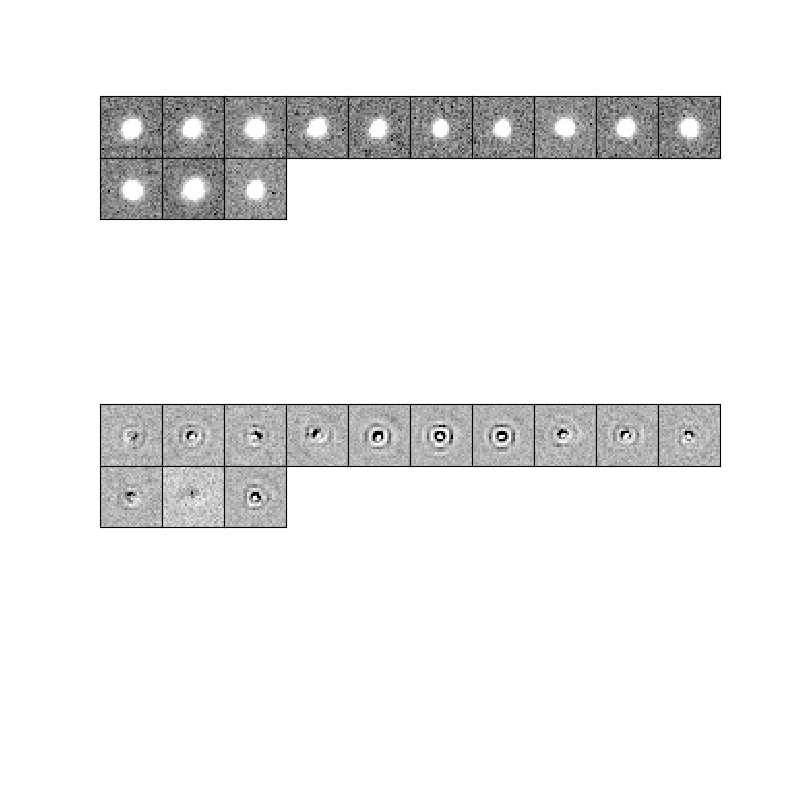

In [17]:
for obj in cwpObjMiniList:
    plot_lightcurve(cwpRepo, cwpTemplateRepo, obj, patch, cwpObjTable, plotAllCutouts=True)